In [1]:
import argparse
import os
import numpy as np
import math
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch

### 设置参数

In [2]:
epochs = 200
batch_size = 128
lr = 0.0002          #adam: learning rate
b1 = 0.5
b2 = 0.999
latent_dim = 100      #隐藏层神经元数
img_size = 64         #生成图片的大小
channels = 3          #图片通道
sample_interval =400  #打印图片间隔
savepath = "images"   #存放图片地址

### 若有GPU，后面方便to device

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### 定义初始化权重函数

In [4]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)   
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)    
        torch.nn.init.constant_(m.bias.data, 0.0)

### 定义生成器

BN + 上采用 + 卷积 + BN + ReLU + 上采用 + 卷积 + BN + ReLU + 卷积   最后用tanh返回-1 1 

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size = img_size // 4
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)   #从一维变成size*size的二维
        img = self.conv_blocks(out)
        return img

### 定义分类器

(卷积 + ReLU + Dropout)*4 + FC

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3,stride = 2, padding=1), 
                     nn.LeakyReLU(0.2, inplace=True), 
                     nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = img_size // 2 ** 4
        self.adv_layer = nn.Sequential(
            nn.Linear(128 * ds_size ** 2, 1), 
            nn.Sigmoid(),
        )

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)    #铺平参数
        validity = self.adv_layer(out)     #全连接层，sigmoid计算概率

        return validity

### 定义损失函数

In [7]:
adversarial_loss = torch.nn.BCELoss()

### 初始化生成器和分类器，并将其扔进GPU里

In [8]:
generator = Generator()
discriminator = Discriminator()

#放入GPU中，为了无GPU也能跑，直接to device

generator.to(device)
discriminator.to(device)
adversarial_loss.to(device)


BCELoss()

In [65]:
#初始化生成器和分类器的权重
generator.apply(weights_init_normal)

Generator(
  (l1): Sequential(
    (0): Linear(in_features=100, out_features=32768, bias=True)
  )
  (conv_blocks): Sequential(
    (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Upsample(scale_factor=2.0, mode=nearest)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Upsample(scale_factor=2.0, mode=nearest)
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Tanh()
  )
)

In [66]:
discriminator.apply(weights_init_normal)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout2d(p=0.25, inplace=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout2d(p=0.25, inplace=False)
    (6): BatchNorm2d(32, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Dropout2d(p=0.25, inplace=False)
    (10): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (12): LeakyReLU(negative_slope=0.2, inplace=True)
    (13): Dropout2d(p=0.25, inplace=False)
    (14): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  )
  (adv_laye

### 创建动漫图片的dataset

In [48]:
from torchvision.datasets import ImageFolder

dataset = ImageFolder(r'dd',transform=transforms.Compose(
            [transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]
        ))

### 将数据集打包进dataloader里

In [49]:
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
)

In [ ]:
'''   MNIST数据集的dataloader
os.makedirs("mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(opt.img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=opt.batch_size,
    shuffle=True,
    num_workers = 4,
    pin_memory=True
)
'''

### 设置优化器（Adam）

In [50]:
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

In [51]:
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor   #方便调用cuda.FloatTensor

### 开始训练

In [52]:
def train():
    global generator,discriminator,optimizer_G,optimizer_D,dataloader,adversarial_loss,epochs,sample_interval
    os.makedirs(savepath, exist_ok=True)
    for epoch in range(epochs):
        for i, (imgs, _) in enumerate(dataloader):

            # 创建ground truth
            valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
            fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)

            # 输入真实图片
            real_imgs = Variable(imgs.type(Tensor))

            # -----------------
            #  训练生成器
            # -----------------

            optimizer_G.zero_grad()

            # 随机创建生成器的输入噪声（0.1）
            z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))

            # 通过生成器生成假图片
            gen_imgs = generator(z)

            # 损失函数计算
            g_loss = adversarial_loss(discriminator(gen_imgs), valid)

            g_loss.backward()
            optimizer_G.step()

            # ---------------------
            #  训练分类器
            # ---------------------

            optimizer_D.zero_grad()

            # 计算损失，优化权重
            real_loss = adversarial_loss(discriminator(real_imgs), valid)
            fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
            d_loss = (real_loss + fake_loss) / 2

            d_loss.backward()
            optimizer_D.step()


            # 保存图片，方便看
            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch, epochs, i, len(dataloader), d_loss.item(), g_loss.item())
            )

            batches_done = epoch * len(dataloader) + i
            if batches_done % sample_interval == 0:
                save_image(gen_imgs.data[:25], savepath+"/%d.png" % batches_done, nrow=5, normalize=True)

In [53]:
train()

[Epoch 0/200] [Batch 0/169] [D loss: 0.693130] [G loss: 0.686500]
[Epoch 0/200] [Batch 1/169] [D loss: 0.693037] [G loss: 0.687133]
[Epoch 0/200] [Batch 2/169] [D loss: 0.692899] [G loss: 0.687740]
[Epoch 0/200] [Batch 3/169] [D loss: 0.692831] [G loss: 0.688273]
[Epoch 0/200] [Batch 4/169] [D loss: 0.692640] [G loss: 0.688865]
[Epoch 0/200] [Batch 5/169] [D loss: 0.692474] [G loss: 0.689406]
[Epoch 0/200] [Batch 6/169] [D loss: 0.692090] [G loss: 0.689783]
[Epoch 0/200] [Batch 7/169] [D loss: 0.691623] [G loss: 0.690319]
[Epoch 0/200] [Batch 8/169] [D loss: 0.691029] [G loss: 0.690791]
[Epoch 0/200] [Batch 9/169] [D loss: 0.690317] [G loss: 0.691211]


KeyboardInterrupt: 

### 保存模型

In [94]:
start = time.time()

torch.save({
            'generator': generator,
            'discriminator': discriminator,
            'optimizer_G': optimizer_G,
            'optimizer_D': optimizer_D
            }, 'net_model.pth')

end = time.time()
print("Running time: %s seconds"%(end - start))

Running time: 0.09508609771728516 seconds


In [82]:
z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))

Running time: 0.0790715217590332 seconds


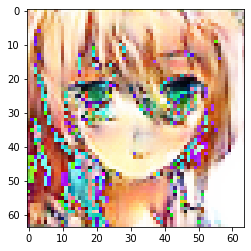

In [95]:
start = time.time()

load = torch.load('net_model.pth')
test_G = load['generator']
import matplotlib.pyplot as plt
dm = test_G(z).data[1].cpu().clone()
unloader = transforms.ToPILImage()
dm = unloader(dm)
plt.imshow(dm)

end = time.time()
print("Running time: %s seconds"%(end - start))

### 保存状态字典

In [98]:
import time 
start = time.time()

torch.save({
            'generator': generator.state_dict(),
            'discriminator': discriminator.state_dict(),
            'optimizer_G': optimizer_G.state_dict(),
            'optimizer_D': optimizer_D.state_dict(),
            'epoch':epochs,
            'g_loss': g_loss,
            'd_loss': d_loss            
            }, 'net_state_dict.pth')

end = time.time()
print("Running time: %s seconds"%(end - start))

Running time: 0.10709762573242188 seconds


Running time: 0.09808802604675293 seconds


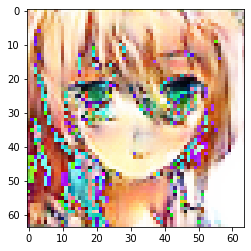

In [97]:
start = time.time()

load2 = torch.load('net_state_dict.pth')
test_G2 = Generator()
test_G2.load_state_dict(load2['generator'])
dm2 = test_G(z).data[1].cpu().clone()
unloader = transforms.ToPILImage()
dm2 = unloader(dm2)
plt.imshow(dm2)

end = time.time()
print("Running time: %s seconds"%(end - start))

### G保留卷积，D不处理

In [62]:
def init_cov(m):
    classname = m.__class__.__name__
    if classname.find("Linear") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)   
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)    
        torch.nn.init.constant_(m.bias.data, 0.0)

In [58]:
### 加载状态字典
load2 = torch.load('net_state_dict.pth')

generator = Generator()
discriminator = Discriminator()
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))



generator.load_state_dict(load2['generator'])
generator.apply(init_cov)              ### 初始化模型，保留卷积层
discriminator.load_state_dict(load2['discriminator'])

generator.to(device)
discriminator.to(device)

optimizer_G.load_state_dict(load2['optimizer_G'])
optimizer_D.load_state_dict(load2['optimizer_D'])




savepath = 'image_cov'

train()



[Epoch 0/200] [Batch 0/169] [D loss: 0.632618] [G loss: 0.877133]
[Epoch 0/200] [Batch 1/169] [D loss: 0.611297] [G loss: 0.897165]
[Epoch 0/200] [Batch 2/169] [D loss: 0.599713] [G loss: 0.849502]
[Epoch 0/200] [Batch 3/169] [D loss: 0.585015] [G loss: 0.791918]
[Epoch 0/200] [Batch 4/169] [D loss: 0.553896] [G loss: 0.815664]
[Epoch 0/200] [Batch 5/169] [D loss: 0.572937] [G loss: 0.802559]
[Epoch 0/200] [Batch 6/169] [D loss: 0.545147] [G loss: 0.801511]
[Epoch 0/200] [Batch 7/169] [D loss: 0.529386] [G loss: 0.779198]
[Epoch 0/200] [Batch 8/169] [D loss: 0.504741] [G loss: 0.838539]
[Epoch 0/200] [Batch 9/169] [D loss: 0.490808] [G loss: 0.874229]
[Epoch 0/200] [Batch 10/169] [D loss: 0.476541] [G loss: 0.851168]
[Epoch 0/200] [Batch 11/169] [D loss: 0.458099] [G loss: 0.838353]
[Epoch 0/200] [Batch 12/169] [D loss: 0.476399] [G loss: 0.846403]
[Epoch 0/200] [Batch 13/169] [D loss: 0.423827] [G loss: 0.953564]
[Epoch 0/200] [Batch 14/169] [D loss: 0.403720] [G loss: 1.121097]
[Epoc

[Epoch 0/200] [Batch 123/169] [D loss: 0.446768] [G loss: 1.103964]
[Epoch 0/200] [Batch 124/169] [D loss: 0.469226] [G loss: 1.350018]
[Epoch 0/200] [Batch 125/169] [D loss: 0.381127] [G loss: 1.323951]
[Epoch 0/200] [Batch 126/169] [D loss: 0.366112] [G loss: 1.385244]
[Epoch 0/200] [Batch 127/169] [D loss: 0.380668] [G loss: 1.409130]
[Epoch 0/200] [Batch 128/169] [D loss: 0.408825] [G loss: 1.202634]
[Epoch 0/200] [Batch 129/169] [D loss: 0.318637] [G loss: 1.311230]
[Epoch 0/200] [Batch 130/169] [D loss: 0.277686] [G loss: 1.694232]
[Epoch 0/200] [Batch 131/169] [D loss: 0.234580] [G loss: 2.055645]
[Epoch 0/200] [Batch 132/169] [D loss: 0.274899] [G loss: 1.751404]
[Epoch 0/200] [Batch 133/169] [D loss: 0.351201] [G loss: 1.523997]
[Epoch 0/200] [Batch 134/169] [D loss: 0.569095] [G loss: 0.924770]
[Epoch 0/200] [Batch 135/169] [D loss: 0.732103] [G loss: 0.682388]
[Epoch 0/200] [Batch 136/169] [D loss: 0.546956] [G loss: 1.388353]
[Epoch 0/200] [Batch 137/169] [D loss: 0.598043]

[Epoch 1/200] [Batch 76/169] [D loss: 0.425317] [G loss: 1.346895]
[Epoch 1/200] [Batch 77/169] [D loss: 0.413117] [G loss: 1.225811]
[Epoch 1/200] [Batch 78/169] [D loss: 0.438852] [G loss: 1.146242]
[Epoch 1/200] [Batch 79/169] [D loss: 0.410465] [G loss: 0.989287]
[Epoch 1/200] [Batch 80/169] [D loss: 0.436997] [G loss: 1.206028]
[Epoch 1/200] [Batch 81/169] [D loss: 0.444312] [G loss: 1.234114]
[Epoch 1/200] [Batch 82/169] [D loss: 0.455893] [G loss: 1.154181]
[Epoch 1/200] [Batch 83/169] [D loss: 0.451498] [G loss: 1.002437]
[Epoch 1/200] [Batch 84/169] [D loss: 0.481442] [G loss: 1.142560]
[Epoch 1/200] [Batch 85/169] [D loss: 0.498527] [G loss: 1.126913]
[Epoch 1/200] [Batch 86/169] [D loss: 0.517869] [G loss: 0.977017]
[Epoch 1/200] [Batch 87/169] [D loss: 0.503821] [G loss: 1.046855]
[Epoch 1/200] [Batch 88/169] [D loss: 0.530214] [G loss: 1.127064]
[Epoch 1/200] [Batch 89/169] [D loss: 0.481113] [G loss: 1.282714]
[Epoch 1/200] [Batch 90/169] [D loss: 0.464378] [G loss: 1.240

[Epoch 2/200] [Batch 29/169] [D loss: 0.347208] [G loss: 1.369420]
[Epoch 2/200] [Batch 30/169] [D loss: 0.376777] [G loss: 1.398186]
[Epoch 2/200] [Batch 31/169] [D loss: 0.422605] [G loss: 1.217917]
[Epoch 2/200] [Batch 32/169] [D loss: 0.479337] [G loss: 1.158295]
[Epoch 2/200] [Batch 33/169] [D loss: 0.529152] [G loss: 0.916237]
[Epoch 2/200] [Batch 34/169] [D loss: 0.554950] [G loss: 1.178490]
[Epoch 2/200] [Batch 35/169] [D loss: 0.457481] [G loss: 1.296301]
[Epoch 2/200] [Batch 36/169] [D loss: 0.360989] [G loss: 1.417593]
[Epoch 2/200] [Batch 37/169] [D loss: 0.350824] [G loss: 1.368347]
[Epoch 2/200] [Batch 38/169] [D loss: 0.345252] [G loss: 1.232623]
[Epoch 2/200] [Batch 39/169] [D loss: 0.445396] [G loss: 1.383200]
[Epoch 2/200] [Batch 40/169] [D loss: 0.441278] [G loss: 1.226698]
[Epoch 2/200] [Batch 41/169] [D loss: 0.448108] [G loss: 1.147378]
[Epoch 2/200] [Batch 42/169] [D loss: 0.482209] [G loss: 1.057613]
[Epoch 2/200] [Batch 43/169] [D loss: 0.466947] [G loss: 1.250

[Epoch 2/200] [Batch 151/169] [D loss: 0.474120] [G loss: 1.256877]
[Epoch 2/200] [Batch 152/169] [D loss: 0.437528] [G loss: 1.222133]
[Epoch 2/200] [Batch 153/169] [D loss: 0.512201] [G loss: 1.177409]
[Epoch 2/200] [Batch 154/169] [D loss: 0.521503] [G loss: 1.193933]
[Epoch 2/200] [Batch 155/169] [D loss: 0.466974] [G loss: 1.199101]
[Epoch 2/200] [Batch 156/169] [D loss: 0.539478] [G loss: 0.940223]
[Epoch 2/200] [Batch 157/169] [D loss: 0.467590] [G loss: 1.120696]
[Epoch 2/200] [Batch 158/169] [D loss: 0.553359] [G loss: 1.202187]
[Epoch 2/200] [Batch 159/169] [D loss: 0.517321] [G loss: 1.260950]
[Epoch 2/200] [Batch 160/169] [D loss: 0.558452] [G loss: 1.373047]
[Epoch 2/200] [Batch 161/169] [D loss: 0.464315] [G loss: 1.050379]
[Epoch 2/200] [Batch 162/169] [D loss: 0.387521] [G loss: 1.361759]
[Epoch 2/200] [Batch 163/169] [D loss: 0.400312] [G loss: 1.756005]
[Epoch 2/200] [Batch 164/169] [D loss: 0.408189] [G loss: 1.383717]
[Epoch 2/200] [Batch 165/169] [D loss: 0.450272]

[Epoch 3/200] [Batch 105/169] [D loss: 0.496527] [G loss: 1.325549]
[Epoch 3/200] [Batch 106/169] [D loss: 0.424088] [G loss: 1.340690]
[Epoch 3/200] [Batch 107/169] [D loss: 0.455951] [G loss: 1.165860]
[Epoch 3/200] [Batch 108/169] [D loss: 0.417066] [G loss: 1.427244]
[Epoch 3/200] [Batch 109/169] [D loss: 0.419821] [G loss: 1.323749]
[Epoch 3/200] [Batch 110/169] [D loss: 0.430138] [G loss: 1.234249]
[Epoch 3/200] [Batch 111/169] [D loss: 0.399492] [G loss: 1.238026]
[Epoch 3/200] [Batch 112/169] [D loss: 0.398928] [G loss: 1.187296]
[Epoch 3/200] [Batch 113/169] [D loss: 0.458102] [G loss: 1.316561]
[Epoch 3/200] [Batch 114/169] [D loss: 0.531448] [G loss: 1.439157]
[Epoch 3/200] [Batch 115/169] [D loss: 0.442730] [G loss: 1.266426]
[Epoch 3/200] [Batch 116/169] [D loss: 0.431110] [G loss: 1.211081]
[Epoch 3/200] [Batch 117/169] [D loss: 0.490963] [G loss: 1.116223]
[Epoch 3/200] [Batch 118/169] [D loss: 0.391874] [G loss: 1.273553]
[Epoch 3/200] [Batch 119/169] [D loss: 0.521484]

[Epoch 4/200] [Batch 58/169] [D loss: 0.459804] [G loss: 1.139495]
[Epoch 4/200] [Batch 59/169] [D loss: 0.510644] [G loss: 0.941976]
[Epoch 4/200] [Batch 60/169] [D loss: 0.541718] [G loss: 1.175361]
[Epoch 4/200] [Batch 61/169] [D loss: 0.537049] [G loss: 1.238907]
[Epoch 4/200] [Batch 62/169] [D loss: 0.488345] [G loss: 1.008180]
[Epoch 4/200] [Batch 63/169] [D loss: 0.577425] [G loss: 1.146655]
[Epoch 4/200] [Batch 64/169] [D loss: 0.534820] [G loss: 1.209145]
[Epoch 4/200] [Batch 65/169] [D loss: 0.521695] [G loss: 1.056037]
[Epoch 4/200] [Batch 66/169] [D loss: 0.466594] [G loss: 1.161083]
[Epoch 4/200] [Batch 67/169] [D loss: 0.489805] [G loss: 1.248984]
[Epoch 4/200] [Batch 68/169] [D loss: 0.515610] [G loss: 1.153428]
[Epoch 4/200] [Batch 69/169] [D loss: 0.489062] [G loss: 0.934608]
[Epoch 4/200] [Batch 70/169] [D loss: 0.483757] [G loss: 1.132715]
[Epoch 4/200] [Batch 71/169] [D loss: 0.498535] [G loss: 1.074770]
[Epoch 4/200] [Batch 72/169] [D loss: 0.487036] [G loss: 1.049

[Epoch 5/200] [Batch 11/169] [D loss: 0.515226] [G loss: 1.236914]
[Epoch 5/200] [Batch 12/169] [D loss: 0.523283] [G loss: 1.053095]
[Epoch 5/200] [Batch 13/169] [D loss: 0.519721] [G loss: 1.026459]
[Epoch 5/200] [Batch 14/169] [D loss: 0.535618] [G loss: 0.933345]
[Epoch 5/200] [Batch 15/169] [D loss: 0.494777] [G loss: 1.199399]
[Epoch 5/200] [Batch 16/169] [D loss: 0.515052] [G loss: 1.320972]
[Epoch 5/200] [Batch 17/169] [D loss: 0.542214] [G loss: 1.144801]
[Epoch 5/200] [Batch 18/169] [D loss: 0.530194] [G loss: 1.194192]
[Epoch 5/200] [Batch 19/169] [D loss: 0.544249] [G loss: 1.226152]
[Epoch 5/200] [Batch 20/169] [D loss: 0.519623] [G loss: 0.904651]
[Epoch 5/200] [Batch 21/169] [D loss: 0.577477] [G loss: 1.147313]
[Epoch 5/200] [Batch 22/169] [D loss: 0.472804] [G loss: 1.072255]
[Epoch 5/200] [Batch 23/169] [D loss: 0.495926] [G loss: 1.060905]
[Epoch 5/200] [Batch 24/169] [D loss: 0.561184] [G loss: 1.065502]
[Epoch 5/200] [Batch 25/169] [D loss: 0.569089] [G loss: 1.081

[Epoch 5/200] [Batch 133/169] [D loss: 0.570557] [G loss: 1.090564]
[Epoch 5/200] [Batch 134/169] [D loss: 0.529400] [G loss: 1.164801]
[Epoch 5/200] [Batch 135/169] [D loss: 0.512588] [G loss: 1.017322]
[Epoch 5/200] [Batch 136/169] [D loss: 0.488371] [G loss: 1.073961]
[Epoch 5/200] [Batch 137/169] [D loss: 0.523481] [G loss: 1.051050]
[Epoch 5/200] [Batch 138/169] [D loss: 0.523330] [G loss: 0.993196]
[Epoch 5/200] [Batch 139/169] [D loss: 0.549156] [G loss: 1.260045]
[Epoch 5/200] [Batch 140/169] [D loss: 0.620564] [G loss: 1.072214]
[Epoch 5/200] [Batch 141/169] [D loss: 0.611525] [G loss: 1.035319]
[Epoch 5/200] [Batch 142/169] [D loss: 0.565983] [G loss: 1.041776]
[Epoch 5/200] [Batch 143/169] [D loss: 0.510758] [G loss: 0.988162]
[Epoch 5/200] [Batch 144/169] [D loss: 0.507815] [G loss: 0.893444]
[Epoch 5/200] [Batch 145/169] [D loss: 0.479684] [G loss: 1.006768]
[Epoch 5/200] [Batch 146/169] [D loss: 0.530029] [G loss: 1.135927]
[Epoch 5/200] [Batch 147/169] [D loss: 0.582418]

[Epoch 6/200] [Batch 86/169] [D loss: 0.530808] [G loss: 1.164933]
[Epoch 6/200] [Batch 87/169] [D loss: 0.506691] [G loss: 1.146908]
[Epoch 6/200] [Batch 88/169] [D loss: 0.509386] [G loss: 1.102808]
[Epoch 6/200] [Batch 89/169] [D loss: 0.510248] [G loss: 1.069929]
[Epoch 6/200] [Batch 90/169] [D loss: 0.472812] [G loss: 1.172777]
[Epoch 6/200] [Batch 91/169] [D loss: 0.460531] [G loss: 1.242897]
[Epoch 6/200] [Batch 92/169] [D loss: 0.498517] [G loss: 1.208761]
[Epoch 6/200] [Batch 93/169] [D loss: 0.465976] [G loss: 1.141811]
[Epoch 6/200] [Batch 94/169] [D loss: 0.492697] [G loss: 1.133975]
[Epoch 6/200] [Batch 95/169] [D loss: 0.492430] [G loss: 1.017207]
[Epoch 6/200] [Batch 96/169] [D loss: 0.468138] [G loss: 0.883600]
[Epoch 6/200] [Batch 97/169] [D loss: 0.553576] [G loss: 1.088908]
[Epoch 6/200] [Batch 98/169] [D loss: 0.541318] [G loss: 0.940075]
[Epoch 6/200] [Batch 99/169] [D loss: 0.572758] [G loss: 1.004861]
[Epoch 6/200] [Batch 100/169] [D loss: 0.649197] [G loss: 1.09

[Epoch 7/200] [Batch 39/169] [D loss: 0.562182] [G loss: 1.289651]
[Epoch 7/200] [Batch 40/169] [D loss: 0.504942] [G loss: 1.203583]
[Epoch 7/200] [Batch 41/169] [D loss: 0.551693] [G loss: 1.113991]
[Epoch 7/200] [Batch 42/169] [D loss: 0.571550] [G loss: 1.104942]
[Epoch 7/200] [Batch 43/169] [D loss: 0.505198] [G loss: 1.115973]
[Epoch 7/200] [Batch 44/169] [D loss: 0.562258] [G loss: 0.931489]
[Epoch 7/200] [Batch 45/169] [D loss: 0.518193] [G loss: 1.120256]
[Epoch 7/200] [Batch 46/169] [D loss: 0.615416] [G loss: 0.846265]
[Epoch 7/200] [Batch 47/169] [D loss: 0.701868] [G loss: 1.042831]
[Epoch 7/200] [Batch 48/169] [D loss: 0.716601] [G loss: 0.821873]
[Epoch 7/200] [Batch 49/169] [D loss: 0.757347] [G loss: 1.047590]
[Epoch 7/200] [Batch 50/169] [D loss: 0.722589] [G loss: 0.736889]
[Epoch 7/200] [Batch 51/169] [D loss: 0.734338] [G loss: 0.849213]
[Epoch 7/200] [Batch 52/169] [D loss: 0.646464] [G loss: 0.865990]
[Epoch 7/200] [Batch 53/169] [D loss: 0.580482] [G loss: 0.967

[Epoch 7/200] [Batch 161/169] [D loss: 0.569835] [G loss: 0.974259]
[Epoch 7/200] [Batch 162/169] [D loss: 0.522572] [G loss: 1.268147]
[Epoch 7/200] [Batch 163/169] [D loss: 0.637800] [G loss: 1.042285]
[Epoch 7/200] [Batch 164/169] [D loss: 0.554345] [G loss: 1.157665]
[Epoch 7/200] [Batch 165/169] [D loss: 0.677591] [G loss: 1.019156]
[Epoch 7/200] [Batch 166/169] [D loss: 0.533469] [G loss: 1.093042]
[Epoch 7/200] [Batch 167/169] [D loss: 0.678944] [G loss: 1.031387]
[Epoch 7/200] [Batch 168/169] [D loss: 0.616042] [G loss: 1.137567]
[Epoch 8/200] [Batch 0/169] [D loss: 0.534438] [G loss: 1.359935]
[Epoch 8/200] [Batch 1/169] [D loss: 0.570934] [G loss: 1.110515]
[Epoch 8/200] [Batch 2/169] [D loss: 0.626018] [G loss: 0.873840]
[Epoch 8/200] [Batch 3/169] [D loss: 0.587521] [G loss: 1.152633]
[Epoch 8/200] [Batch 4/169] [D loss: 0.633369] [G loss: 1.157026]
[Epoch 8/200] [Batch 5/169] [D loss: 0.544097] [G loss: 1.077719]
[Epoch 8/200] [Batch 6/169] [D loss: 0.457858] [G loss: 1.00

[Epoch 8/200] [Batch 115/169] [D loss: 0.666644] [G loss: 0.821041]
[Epoch 8/200] [Batch 116/169] [D loss: 0.589931] [G loss: 0.819690]
[Epoch 8/200] [Batch 117/169] [D loss: 0.720178] [G loss: 1.053456]
[Epoch 8/200] [Batch 118/169] [D loss: 0.633829] [G loss: 1.167297]
[Epoch 8/200] [Batch 119/169] [D loss: 0.521511] [G loss: 1.249382]
[Epoch 8/200] [Batch 120/169] [D loss: 0.550614] [G loss: 1.083667]
[Epoch 8/200] [Batch 121/169] [D loss: 0.400380] [G loss: 1.451246]
[Epoch 8/200] [Batch 122/169] [D loss: 0.578661] [G loss: 0.903726]
[Epoch 8/200] [Batch 123/169] [D loss: 0.512152] [G loss: 0.779722]
[Epoch 8/200] [Batch 124/169] [D loss: 0.560752] [G loss: 0.739482]
[Epoch 8/200] [Batch 125/169] [D loss: 0.604749] [G loss: 0.923812]
[Epoch 8/200] [Batch 126/169] [D loss: 0.605085] [G loss: 0.805895]
[Epoch 8/200] [Batch 127/169] [D loss: 0.620535] [G loss: 1.101751]
[Epoch 8/200] [Batch 128/169] [D loss: 0.590726] [G loss: 1.055071]
[Epoch 8/200] [Batch 129/169] [D loss: 0.567712]

[Epoch 9/200] [Batch 68/169] [D loss: 0.593202] [G loss: 0.976259]
[Epoch 9/200] [Batch 69/169] [D loss: 0.579412] [G loss: 1.044728]
[Epoch 9/200] [Batch 70/169] [D loss: 0.653229] [G loss: 1.210407]
[Epoch 9/200] [Batch 71/169] [D loss: 0.589456] [G loss: 1.030360]
[Epoch 9/200] [Batch 72/169] [D loss: 0.511924] [G loss: 0.967747]
[Epoch 9/200] [Batch 73/169] [D loss: 0.639107] [G loss: 1.160894]
[Epoch 9/200] [Batch 74/169] [D loss: 0.633352] [G loss: 1.135864]
[Epoch 9/200] [Batch 75/169] [D loss: 0.602413] [G loss: 0.963951]
[Epoch 9/200] [Batch 76/169] [D loss: 0.630199] [G loss: 0.912112]
[Epoch 9/200] [Batch 77/169] [D loss: 0.645023] [G loss: 0.948208]
[Epoch 9/200] [Batch 78/169] [D loss: 0.672244] [G loss: 0.887736]
[Epoch 9/200] [Batch 79/169] [D loss: 0.580113] [G loss: 1.091523]
[Epoch 9/200] [Batch 80/169] [D loss: 0.635071] [G loss: 1.194745]
[Epoch 9/200] [Batch 81/169] [D loss: 0.674588] [G loss: 0.724761]
[Epoch 9/200] [Batch 82/169] [D loss: 0.607041] [G loss: 0.810

[Epoch 10/200] [Batch 21/169] [D loss: 0.609617] [G loss: 1.016627]
[Epoch 10/200] [Batch 22/169] [D loss: 0.571683] [G loss: 1.096793]
[Epoch 10/200] [Batch 23/169] [D loss: 0.541966] [G loss: 1.003515]
[Epoch 10/200] [Batch 24/169] [D loss: 0.571420] [G loss: 1.195824]
[Epoch 10/200] [Batch 25/169] [D loss: 0.558205] [G loss: 1.023997]
[Epoch 10/200] [Batch 26/169] [D loss: 0.618968] [G loss: 1.063749]
[Epoch 10/200] [Batch 27/169] [D loss: 0.637837] [G loss: 0.840756]
[Epoch 10/200] [Batch 28/169] [D loss: 0.586611] [G loss: 0.714776]
[Epoch 10/200] [Batch 29/169] [D loss: 0.631717] [G loss: 0.866539]
[Epoch 10/200] [Batch 30/169] [D loss: 0.568800] [G loss: 0.825864]
[Epoch 10/200] [Batch 31/169] [D loss: 0.548076] [G loss: 1.074355]
[Epoch 10/200] [Batch 32/169] [D loss: 0.544914] [G loss: 1.098344]
[Epoch 10/200] [Batch 33/169] [D loss: 0.598858] [G loss: 1.059024]
[Epoch 10/200] [Batch 34/169] [D loss: 0.570325] [G loss: 1.010720]
[Epoch 10/200] [Batch 35/169] [D loss: 0.536623]

[Epoch 10/200] [Batch 141/169] [D loss: 0.555416] [G loss: 0.996407]
[Epoch 10/200] [Batch 142/169] [D loss: 0.604893] [G loss: 0.912513]
[Epoch 10/200] [Batch 143/169] [D loss: 0.604975] [G loss: 1.080710]
[Epoch 10/200] [Batch 144/169] [D loss: 0.593850] [G loss: 0.778568]
[Epoch 10/200] [Batch 145/169] [D loss: 0.627196] [G loss: 0.898029]
[Epoch 10/200] [Batch 146/169] [D loss: 0.661937] [G loss: 0.990554]
[Epoch 10/200] [Batch 147/169] [D loss: 0.596649] [G loss: 1.007113]
[Epoch 10/200] [Batch 148/169] [D loss: 0.539033] [G loss: 1.088514]
[Epoch 10/200] [Batch 149/169] [D loss: 0.635422] [G loss: 1.219337]
[Epoch 10/200] [Batch 150/169] [D loss: 0.579107] [G loss: 1.024012]
[Epoch 10/200] [Batch 151/169] [D loss: 0.579256] [G loss: 1.031120]
[Epoch 10/200] [Batch 152/169] [D loss: 0.546231] [G loss: 1.094738]
[Epoch 10/200] [Batch 153/169] [D loss: 0.570625] [G loss: 1.039950]
[Epoch 10/200] [Batch 154/169] [D loss: 0.606004] [G loss: 1.011290]
[Epoch 10/200] [Batch 155/169] [D 

[Epoch 11/200] [Batch 93/169] [D loss: 0.673670] [G loss: 0.787581]
[Epoch 11/200] [Batch 94/169] [D loss: 0.637334] [G loss: 0.751176]
[Epoch 11/200] [Batch 95/169] [D loss: 0.643359] [G loss: 0.878118]
[Epoch 11/200] [Batch 96/169] [D loss: 0.638985] [G loss: 0.846507]
[Epoch 11/200] [Batch 97/169] [D loss: 0.605037] [G loss: 0.893900]
[Epoch 11/200] [Batch 98/169] [D loss: 0.569045] [G loss: 0.817327]
[Epoch 11/200] [Batch 99/169] [D loss: 0.699050] [G loss: 0.965618]
[Epoch 11/200] [Batch 100/169] [D loss: 0.513046] [G loss: 0.989777]
[Epoch 11/200] [Batch 101/169] [D loss: 0.581081] [G loss: 0.976429]
[Epoch 11/200] [Batch 102/169] [D loss: 0.621312] [G loss: 0.926049]
[Epoch 11/200] [Batch 103/169] [D loss: 0.609087] [G loss: 0.937230]
[Epoch 11/200] [Batch 104/169] [D loss: 0.599059] [G loss: 0.805748]
[Epoch 11/200] [Batch 105/169] [D loss: 0.644927] [G loss: 1.007493]
[Epoch 11/200] [Batch 106/169] [D loss: 0.704082] [G loss: 0.967355]
[Epoch 11/200] [Batch 107/169] [D loss: 0

[Epoch 12/200] [Batch 44/169] [D loss: 0.547235] [G loss: 1.213462]
[Epoch 12/200] [Batch 45/169] [D loss: 0.546737] [G loss: 1.106593]
[Epoch 12/200] [Batch 46/169] [D loss: 0.589981] [G loss: 1.068954]
[Epoch 12/200] [Batch 47/169] [D loss: 0.687094] [G loss: 0.996995]
[Epoch 12/200] [Batch 48/169] [D loss: 0.642777] [G loss: 0.982173]
[Epoch 12/200] [Batch 49/169] [D loss: 0.583744] [G loss: 0.850279]
[Epoch 12/200] [Batch 50/169] [D loss: 0.582685] [G loss: 1.055396]
[Epoch 12/200] [Batch 51/169] [D loss: 0.617519] [G loss: 1.058091]
[Epoch 12/200] [Batch 52/169] [D loss: 0.640266] [G loss: 0.906410]
[Epoch 12/200] [Batch 53/169] [D loss: 0.599584] [G loss: 0.990796]
[Epoch 12/200] [Batch 54/169] [D loss: 0.556371] [G loss: 0.910007]
[Epoch 12/200] [Batch 55/169] [D loss: 0.591602] [G loss: 1.056597]
[Epoch 12/200] [Batch 56/169] [D loss: 0.635627] [G loss: 1.193032]
[Epoch 12/200] [Batch 57/169] [D loss: 0.506154] [G loss: 1.062923]
[Epoch 12/200] [Batch 58/169] [D loss: 0.615358]

[Epoch 12/200] [Batch 164/169] [D loss: 0.604441] [G loss: 1.018763]
[Epoch 12/200] [Batch 165/169] [D loss: 0.737135] [G loss: 0.770154]
[Epoch 12/200] [Batch 166/169] [D loss: 0.648328] [G loss: 0.982560]
[Epoch 12/200] [Batch 167/169] [D loss: 0.612971] [G loss: 1.150991]
[Epoch 12/200] [Batch 168/169] [D loss: 0.721237] [G loss: 0.962701]
[Epoch 13/200] [Batch 0/169] [D loss: 0.707469] [G loss: 0.779818]
[Epoch 13/200] [Batch 1/169] [D loss: 0.608387] [G loss: 1.089892]
[Epoch 13/200] [Batch 2/169] [D loss: 0.534409] [G loss: 1.205296]
[Epoch 13/200] [Batch 3/169] [D loss: 0.582670] [G loss: 1.197287]
[Epoch 13/200] [Batch 4/169] [D loss: 0.543452] [G loss: 0.925258]
[Epoch 13/200] [Batch 5/169] [D loss: 0.622160] [G loss: 0.719671]
[Epoch 13/200] [Batch 6/169] [D loss: 0.706596] [G loss: 0.821834]
[Epoch 13/200] [Batch 7/169] [D loss: 0.611757] [G loss: 0.970493]
[Epoch 13/200] [Batch 8/169] [D loss: 0.662591] [G loss: 1.200159]
[Epoch 13/200] [Batch 9/169] [D loss: 0.541294] [G l

[Epoch 13/200] [Batch 116/169] [D loss: 0.652986] [G loss: 0.929356]
[Epoch 13/200] [Batch 117/169] [D loss: 0.693142] [G loss: 1.083025]
[Epoch 13/200] [Batch 118/169] [D loss: 0.689308] [G loss: 1.148791]
[Epoch 13/200] [Batch 119/169] [D loss: 0.691989] [G loss: 1.007993]
[Epoch 13/200] [Batch 120/169] [D loss: 0.614511] [G loss: 0.757556]
[Epoch 13/200] [Batch 121/169] [D loss: 0.589284] [G loss: 0.949663]
[Epoch 13/200] [Batch 122/169] [D loss: 0.547139] [G loss: 0.873453]
[Epoch 13/200] [Batch 123/169] [D loss: 0.627460] [G loss: 0.866760]
[Epoch 13/200] [Batch 124/169] [D loss: 0.657822] [G loss: 0.872197]
[Epoch 13/200] [Batch 125/169] [D loss: 0.696123] [G loss: 1.007483]
[Epoch 13/200] [Batch 126/169] [D loss: 0.644670] [G loss: 0.752566]
[Epoch 13/200] [Batch 127/169] [D loss: 0.555923] [G loss: 0.856929]
[Epoch 13/200] [Batch 128/169] [D loss: 0.643884] [G loss: 0.993937]
[Epoch 13/200] [Batch 129/169] [D loss: 0.546633] [G loss: 0.858033]
[Epoch 13/200] [Batch 130/169] [D 

[Epoch 14/200] [Batch 67/169] [D loss: 0.584148] [G loss: 0.961323]
[Epoch 14/200] [Batch 68/169] [D loss: 0.549646] [G loss: 0.953048]
[Epoch 14/200] [Batch 69/169] [D loss: 0.562899] [G loss: 0.957810]
[Epoch 14/200] [Batch 70/169] [D loss: 0.637143] [G loss: 0.773812]
[Epoch 14/200] [Batch 71/169] [D loss: 0.624034] [G loss: 0.976057]
[Epoch 14/200] [Batch 72/169] [D loss: 0.613928] [G loss: 0.939028]
[Epoch 14/200] [Batch 73/169] [D loss: 0.536086] [G loss: 1.017677]
[Epoch 14/200] [Batch 74/169] [D loss: 0.676094] [G loss: 0.783602]
[Epoch 14/200] [Batch 75/169] [D loss: 0.651095] [G loss: 0.971158]
[Epoch 14/200] [Batch 76/169] [D loss: 0.624838] [G loss: 0.899081]
[Epoch 14/200] [Batch 77/169] [D loss: 0.643992] [G loss: 1.099472]
[Epoch 14/200] [Batch 78/169] [D loss: 0.632893] [G loss: 0.964718]
[Epoch 14/200] [Batch 79/169] [D loss: 0.626527] [G loss: 0.772312]
[Epoch 14/200] [Batch 80/169] [D loss: 0.579701] [G loss: 0.833560]
[Epoch 14/200] [Batch 81/169] [D loss: 0.632146]

[Epoch 15/200] [Batch 18/169] [D loss: 0.567769] [G loss: 1.075715]
[Epoch 15/200] [Batch 19/169] [D loss: 0.543836] [G loss: 0.970950]
[Epoch 15/200] [Batch 20/169] [D loss: 0.580381] [G loss: 0.911730]
[Epoch 15/200] [Batch 21/169] [D loss: 0.572160] [G loss: 0.882929]
[Epoch 15/200] [Batch 22/169] [D loss: 0.550895] [G loss: 0.914494]
[Epoch 15/200] [Batch 23/169] [D loss: 0.582282] [G loss: 1.033518]
[Epoch 15/200] [Batch 24/169] [D loss: 0.642606] [G loss: 1.040784]
[Epoch 15/200] [Batch 25/169] [D loss: 0.560637] [G loss: 0.933025]
[Epoch 15/200] [Batch 26/169] [D loss: 0.621415] [G loss: 0.822153]
[Epoch 15/200] [Batch 27/169] [D loss: 0.633366] [G loss: 0.791002]
[Epoch 15/200] [Batch 28/169] [D loss: 0.720376] [G loss: 0.817704]
[Epoch 15/200] [Batch 29/169] [D loss: 0.627797] [G loss: 0.811639]
[Epoch 15/200] [Batch 30/169] [D loss: 0.774457] [G loss: 0.844193]
[Epoch 15/200] [Batch 31/169] [D loss: 0.743722] [G loss: 0.945169]
[Epoch 15/200] [Batch 32/169] [D loss: 0.634007]

[Epoch 15/200] [Batch 138/169] [D loss: 0.586401] [G loss: 1.013102]
[Epoch 15/200] [Batch 139/169] [D loss: 0.577832] [G loss: 0.820634]
[Epoch 15/200] [Batch 140/169] [D loss: 0.588507] [G loss: 0.876953]
[Epoch 15/200] [Batch 141/169] [D loss: 0.606912] [G loss: 0.935601]
[Epoch 15/200] [Batch 142/169] [D loss: 0.636998] [G loss: 0.959370]
[Epoch 15/200] [Batch 143/169] [D loss: 0.636858] [G loss: 0.889704]
[Epoch 15/200] [Batch 144/169] [D loss: 0.556883] [G loss: 0.781362]
[Epoch 15/200] [Batch 145/169] [D loss: 0.648567] [G loss: 0.868272]
[Epoch 15/200] [Batch 146/169] [D loss: 0.622762] [G loss: 0.980942]
[Epoch 15/200] [Batch 147/169] [D loss: 0.622267] [G loss: 0.885860]
[Epoch 15/200] [Batch 148/169] [D loss: 0.687290] [G loss: 0.787119]
[Epoch 15/200] [Batch 149/169] [D loss: 0.665170] [G loss: 0.955528]
[Epoch 15/200] [Batch 150/169] [D loss: 0.660410] [G loss: 0.905804]
[Epoch 15/200] [Batch 151/169] [D loss: 0.680130] [G loss: 0.860054]
[Epoch 15/200] [Batch 152/169] [D 

[Epoch 16/200] [Batch 90/169] [D loss: 0.574514] [G loss: 0.719843]
[Epoch 16/200] [Batch 91/169] [D loss: 0.635901] [G loss: 1.024879]
[Epoch 16/200] [Batch 92/169] [D loss: 0.621653] [G loss: 0.876608]
[Epoch 16/200] [Batch 93/169] [D loss: 0.624285] [G loss: 1.040370]
[Epoch 16/200] [Batch 94/169] [D loss: 0.622109] [G loss: 0.987043]
[Epoch 16/200] [Batch 95/169] [D loss: 0.642080] [G loss: 1.260003]
[Epoch 16/200] [Batch 96/169] [D loss: 0.569519] [G loss: 0.923107]
[Epoch 16/200] [Batch 97/169] [D loss: 0.546780] [G loss: 0.999953]
[Epoch 16/200] [Batch 98/169] [D loss: 0.579167] [G loss: 0.883667]
[Epoch 16/200] [Batch 99/169] [D loss: 0.583578] [G loss: 0.856824]
[Epoch 16/200] [Batch 100/169] [D loss: 0.639751] [G loss: 0.894557]
[Epoch 16/200] [Batch 101/169] [D loss: 0.613905] [G loss: 1.035528]
[Epoch 16/200] [Batch 102/169] [D loss: 0.632876] [G loss: 1.043569]
[Epoch 16/200] [Batch 103/169] [D loss: 0.640819] [G loss: 1.104089]
[Epoch 16/200] [Batch 104/169] [D loss: 0.59

[Epoch 17/200] [Batch 41/169] [D loss: 0.593764] [G loss: 1.001930]
[Epoch 17/200] [Batch 42/169] [D loss: 0.610156] [G loss: 0.937733]
[Epoch 17/200] [Batch 43/169] [D loss: 0.577818] [G loss: 0.850717]
[Epoch 17/200] [Batch 44/169] [D loss: 0.584636] [G loss: 0.791626]
[Epoch 17/200] [Batch 45/169] [D loss: 0.550317] [G loss: 0.911182]
[Epoch 17/200] [Batch 46/169] [D loss: 0.648255] [G loss: 0.897390]
[Epoch 17/200] [Batch 47/169] [D loss: 0.663135] [G loss: 0.831074]
[Epoch 17/200] [Batch 48/169] [D loss: 0.745214] [G loss: 0.782403]
[Epoch 17/200] [Batch 49/169] [D loss: 0.647973] [G loss: 0.810870]
[Epoch 17/200] [Batch 50/169] [D loss: 0.676190] [G loss: 0.798654]
[Epoch 17/200] [Batch 51/169] [D loss: 0.650642] [G loss: 0.913082]
[Epoch 17/200] [Batch 52/169] [D loss: 0.650669] [G loss: 1.058891]
[Epoch 17/200] [Batch 53/169] [D loss: 0.587942] [G loss: 0.922577]
[Epoch 17/200] [Batch 54/169] [D loss: 0.560773] [G loss: 0.977577]
[Epoch 17/200] [Batch 55/169] [D loss: 0.585379]

[Epoch 17/200] [Batch 161/169] [D loss: 0.647509] [G loss: 0.886408]
[Epoch 17/200] [Batch 162/169] [D loss: 0.664262] [G loss: 0.903627]
[Epoch 17/200] [Batch 163/169] [D loss: 0.624481] [G loss: 1.008884]
[Epoch 17/200] [Batch 164/169] [D loss: 0.647835] [G loss: 1.012434]
[Epoch 17/200] [Batch 165/169] [D loss: 0.607301] [G loss: 0.855097]
[Epoch 17/200] [Batch 166/169] [D loss: 0.604520] [G loss: 1.056113]
[Epoch 17/200] [Batch 167/169] [D loss: 0.614170] [G loss: 0.987646]
[Epoch 17/200] [Batch 168/169] [D loss: 0.694908] [G loss: 0.919382]
[Epoch 18/200] [Batch 0/169] [D loss: 0.649339] [G loss: 0.869538]
[Epoch 18/200] [Batch 1/169] [D loss: 0.621392] [G loss: 0.754779]
[Epoch 18/200] [Batch 2/169] [D loss: 0.606870] [G loss: 0.987282]
[Epoch 18/200] [Batch 3/169] [D loss: 0.664824] [G loss: 0.952013]
[Epoch 18/200] [Batch 4/169] [D loss: 0.704560] [G loss: 0.905306]
[Epoch 18/200] [Batch 5/169] [D loss: 0.541070] [G loss: 1.015122]
[Epoch 18/200] [Batch 6/169] [D loss: 0.601638

[Epoch 18/200] [Batch 113/169] [D loss: 0.677748] [G loss: 0.854733]
[Epoch 18/200] [Batch 114/169] [D loss: 0.587078] [G loss: 0.930628]
[Epoch 18/200] [Batch 115/169] [D loss: 0.607578] [G loss: 0.900994]
[Epoch 18/200] [Batch 116/169] [D loss: 0.579241] [G loss: 0.760522]
[Epoch 18/200] [Batch 117/169] [D loss: 0.664859] [G loss: 0.864815]
[Epoch 18/200] [Batch 118/169] [D loss: 0.768026] [G loss: 0.976598]
[Epoch 18/200] [Batch 119/169] [D loss: 0.558227] [G loss: 0.977689]
[Epoch 18/200] [Batch 120/169] [D loss: 0.627057] [G loss: 0.886807]
[Epoch 18/200] [Batch 121/169] [D loss: 0.589175] [G loss: 0.776650]
[Epoch 18/200] [Batch 122/169] [D loss: 0.638399] [G loss: 0.682860]
[Epoch 18/200] [Batch 123/169] [D loss: 0.659869] [G loss: 0.793192]
[Epoch 18/200] [Batch 124/169] [D loss: 0.597048] [G loss: 1.034590]
[Epoch 18/200] [Batch 125/169] [D loss: 0.577486] [G loss: 1.008065]
[Epoch 18/200] [Batch 126/169] [D loss: 0.642726] [G loss: 0.800647]
[Epoch 18/200] [Batch 127/169] [D 

[Epoch 19/200] [Batch 64/169] [D loss: 0.653195] [G loss: 0.871544]
[Epoch 19/200] [Batch 65/169] [D loss: 0.593001] [G loss: 0.858922]
[Epoch 19/200] [Batch 66/169] [D loss: 0.597192] [G loss: 0.979654]
[Epoch 19/200] [Batch 67/169] [D loss: 0.622065] [G loss: 0.844052]
[Epoch 19/200] [Batch 68/169] [D loss: 0.653740] [G loss: 0.903730]
[Epoch 19/200] [Batch 69/169] [D loss: 0.607424] [G loss: 0.947982]
[Epoch 19/200] [Batch 70/169] [D loss: 0.622393] [G loss: 0.877775]
[Epoch 19/200] [Batch 71/169] [D loss: 0.676621] [G loss: 0.900136]
[Epoch 19/200] [Batch 72/169] [D loss: 0.580030] [G loss: 0.848233]
[Epoch 19/200] [Batch 73/169] [D loss: 0.599778] [G loss: 0.933880]
[Epoch 19/200] [Batch 74/169] [D loss: 0.629687] [G loss: 0.882631]
[Epoch 19/200] [Batch 75/169] [D loss: 0.612517] [G loss: 0.957603]
[Epoch 19/200] [Batch 76/169] [D loss: 0.642745] [G loss: 0.942932]
[Epoch 19/200] [Batch 77/169] [D loss: 0.608735] [G loss: 0.953297]
[Epoch 19/200] [Batch 78/169] [D loss: 0.619875]

[Epoch 20/200] [Batch 15/169] [D loss: 0.669773] [G loss: 0.891715]
[Epoch 20/200] [Batch 16/169] [D loss: 0.613760] [G loss: 0.946681]
[Epoch 20/200] [Batch 17/169] [D loss: 0.687044] [G loss: 0.942785]
[Epoch 20/200] [Batch 18/169] [D loss: 0.621166] [G loss: 0.874158]
[Epoch 20/200] [Batch 19/169] [D loss: 0.680837] [G loss: 0.965666]
[Epoch 20/200] [Batch 20/169] [D loss: 0.668378] [G loss: 0.860322]
[Epoch 20/200] [Batch 21/169] [D loss: 0.685725] [G loss: 0.879948]
[Epoch 20/200] [Batch 22/169] [D loss: 0.703165] [G loss: 1.030895]
[Epoch 20/200] [Batch 23/169] [D loss: 0.666961] [G loss: 1.139306]
[Epoch 20/200] [Batch 24/169] [D loss: 0.683949] [G loss: 0.944733]
[Epoch 20/200] [Batch 25/169] [D loss: 0.619657] [G loss: 0.872959]
[Epoch 20/200] [Batch 26/169] [D loss: 0.639254] [G loss: 0.871268]
[Epoch 20/200] [Batch 27/169] [D loss: 0.611029] [G loss: 0.774227]
[Epoch 20/200] [Batch 28/169] [D loss: 0.712884] [G loss: 0.810821]
[Epoch 20/200] [Batch 29/169] [D loss: 0.699940]

[Epoch 20/200] [Batch 135/169] [D loss: 0.615220] [G loss: 0.926103]
[Epoch 20/200] [Batch 136/169] [D loss: 0.735245] [G loss: 0.822039]
[Epoch 20/200] [Batch 137/169] [D loss: 0.627302] [G loss: 0.881709]
[Epoch 20/200] [Batch 138/169] [D loss: 0.602013] [G loss: 0.892190]
[Epoch 20/200] [Batch 139/169] [D loss: 0.565463] [G loss: 1.012756]
[Epoch 20/200] [Batch 140/169] [D loss: 0.611988] [G loss: 0.787462]
[Epoch 20/200] [Batch 141/169] [D loss: 0.620560] [G loss: 0.989886]
[Epoch 20/200] [Batch 142/169] [D loss: 0.626476] [G loss: 0.990077]
[Epoch 20/200] [Batch 143/169] [D loss: 0.592290] [G loss: 1.001430]
[Epoch 20/200] [Batch 144/169] [D loss: 0.622060] [G loss: 0.946106]
[Epoch 20/200] [Batch 145/169] [D loss: 0.638999] [G loss: 0.880408]
[Epoch 20/200] [Batch 146/169] [D loss: 0.603555] [G loss: 0.981259]
[Epoch 20/200] [Batch 147/169] [D loss: 0.670393] [G loss: 0.898321]
[Epoch 20/200] [Batch 148/169] [D loss: 0.718968] [G loss: 0.904170]
[Epoch 20/200] [Batch 149/169] [D 

[Epoch 21/200] [Batch 87/169] [D loss: 0.655070] [G loss: 0.947471]
[Epoch 21/200] [Batch 88/169] [D loss: 0.610797] [G loss: 0.972158]
[Epoch 21/200] [Batch 89/169] [D loss: 0.596357] [G loss: 0.886848]
[Epoch 21/200] [Batch 90/169] [D loss: 0.626216] [G loss: 0.865195]
[Epoch 21/200] [Batch 91/169] [D loss: 0.691012] [G loss: 0.911677]
[Epoch 21/200] [Batch 92/169] [D loss: 0.644688] [G loss: 0.850139]
[Epoch 21/200] [Batch 93/169] [D loss: 0.666046] [G loss: 0.950624]
[Epoch 21/200] [Batch 94/169] [D loss: 0.615076] [G loss: 0.971387]
[Epoch 21/200] [Batch 95/169] [D loss: 0.699023] [G loss: 0.985424]
[Epoch 21/200] [Batch 96/169] [D loss: 0.629767] [G loss: 0.768441]
[Epoch 21/200] [Batch 97/169] [D loss: 0.638601] [G loss: 0.786056]
[Epoch 21/200] [Batch 98/169] [D loss: 0.644164] [G loss: 0.922920]
[Epoch 21/200] [Batch 99/169] [D loss: 0.599668] [G loss: 0.835704]
[Epoch 21/200] [Batch 100/169] [D loss: 0.583534] [G loss: 0.868908]
[Epoch 21/200] [Batch 101/169] [D loss: 0.64769

RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:73] data. DefaultCPUAllocator: not enough memory: you tried to allocate 6291456 bytes. Buy new RAM!

### G保留卷积，D同样

In [63]:
### 加载状态字典
load2 = torch.load('net_state_dict.pth')

generator = Generator()
discriminator = Discriminator()
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))



generator.load_state_dict(load2['generator'])
generator.apply(init_cov)              ### 初始化模型，保留卷积层
discriminator.load_state_dict(load2['discriminator'])
discriminator.apply(init_cov)
generator.to(device)
discriminator.to(device)

optimizer_G.load_state_dict(load2['optimizer_G'])
optimizer_D.load_state_dict(load2['optimizer_D'])




savepath = 'image_cov_GD'

train()


[Epoch 0/200] [Batch 0/169] [D loss: 0.706744] [G loss: 0.659710]
[Epoch 0/200] [Batch 1/169] [D loss: 0.703107] [G loss: 0.659453]
[Epoch 0/200] [Batch 2/169] [D loss: 0.706694] [G loss: 0.669835]
[Epoch 0/200] [Batch 3/169] [D loss: 0.697640] [G loss: 0.695723]
[Epoch 0/200] [Batch 4/169] [D loss: 0.686661] [G loss: 0.730310]
[Epoch 0/200] [Batch 5/169] [D loss: 0.675556] [G loss: 0.773826]
[Epoch 0/200] [Batch 6/169] [D loss: 0.662284] [G loss: 0.795079]
[Epoch 0/200] [Batch 7/169] [D loss: 0.657457] [G loss: 0.816485]
[Epoch 0/200] [Batch 8/169] [D loss: 0.656678] [G loss: 0.816324]
[Epoch 0/200] [Batch 9/169] [D loss: 0.683151] [G loss: 0.774808]
[Epoch 0/200] [Batch 10/169] [D loss: 0.705304] [G loss: 0.719674]
[Epoch 0/200] [Batch 11/169] [D loss: 0.708868] [G loss: 0.706347]
[Epoch 0/200] [Batch 12/169] [D loss: 0.697540] [G loss: 0.706158]
[Epoch 0/200] [Batch 13/169] [D loss: 0.694833] [G loss: 0.720033]
[Epoch 0/200] [Batch 14/169] [D loss: 0.692508] [G loss: 0.727006]
[Epoc

[Epoch 0/200] [Batch 123/169] [D loss: 0.678994] [G loss: 0.716090]
[Epoch 0/200] [Batch 124/169] [D loss: 0.665372] [G loss: 0.724456]
[Epoch 0/200] [Batch 125/169] [D loss: 0.658498] [G loss: 0.735632]
[Epoch 0/200] [Batch 126/169] [D loss: 0.654507] [G loss: 0.727231]
[Epoch 0/200] [Batch 127/169] [D loss: 0.660293] [G loss: 0.727102]
[Epoch 0/200] [Batch 128/169] [D loss: 0.651572] [G loss: 0.731427]
[Epoch 0/200] [Batch 129/169] [D loss: 0.644395] [G loss: 0.738096]
[Epoch 0/200] [Batch 130/169] [D loss: 0.648315] [G loss: 0.729369]
[Epoch 0/200] [Batch 131/169] [D loss: 0.637744] [G loss: 0.734709]
[Epoch 0/200] [Batch 132/169] [D loss: 0.634546] [G loss: 0.731067]
[Epoch 0/200] [Batch 133/169] [D loss: 0.634173] [G loss: 0.741003]
[Epoch 0/200] [Batch 134/169] [D loss: 0.620879] [G loss: 0.732057]
[Epoch 0/200] [Batch 135/169] [D loss: 0.619055] [G loss: 0.732477]
[Epoch 0/200] [Batch 136/169] [D loss: 0.625288] [G loss: 0.738744]
[Epoch 0/200] [Batch 137/169] [D loss: 0.609287]

[Epoch 1/200] [Batch 76/169] [D loss: 0.673004] [G loss: 0.856007]
[Epoch 1/200] [Batch 77/169] [D loss: 0.655492] [G loss: 0.869196]
[Epoch 1/200] [Batch 78/169] [D loss: 0.648015] [G loss: 0.874380]
[Epoch 1/200] [Batch 79/169] [D loss: 0.648123] [G loss: 0.879005]
[Epoch 1/200] [Batch 80/169] [D loss: 0.649476] [G loss: 0.856799]
[Epoch 1/200] [Batch 81/169] [D loss: 0.645017] [G loss: 0.835137]
[Epoch 1/200] [Batch 82/169] [D loss: 0.643040] [G loss: 0.812838]
[Epoch 1/200] [Batch 83/169] [D loss: 0.644529] [G loss: 0.788351]
[Epoch 1/200] [Batch 84/169] [D loss: 0.645880] [G loss: 0.774351]
[Epoch 1/200] [Batch 85/169] [D loss: 0.652454] [G loss: 0.741788]
[Epoch 1/200] [Batch 86/169] [D loss: 0.677211] [G loss: 0.747531]
[Epoch 1/200] [Batch 87/169] [D loss: 0.661615] [G loss: 0.739434]
[Epoch 1/200] [Batch 88/169] [D loss: 0.668949] [G loss: 0.748623]
[Epoch 1/200] [Batch 89/169] [D loss: 0.665399] [G loss: 0.737249]
[Epoch 1/200] [Batch 90/169] [D loss: 0.668320] [G loss: 0.751

[Epoch 2/200] [Batch 29/169] [D loss: 0.695791] [G loss: 0.631353]
[Epoch 2/200] [Batch 30/169] [D loss: 0.679967] [G loss: 0.648125]
[Epoch 2/200] [Batch 31/169] [D loss: 0.664077] [G loss: 0.692651]
[Epoch 2/200] [Batch 32/169] [D loss: 0.644766] [G loss: 0.713724]
[Epoch 2/200] [Batch 33/169] [D loss: 0.645715] [G loss: 0.711834]
[Epoch 2/200] [Batch 34/169] [D loss: 0.676829] [G loss: 0.710670]
[Epoch 2/200] [Batch 35/169] [D loss: 0.700303] [G loss: 0.694945]
[Epoch 2/200] [Batch 36/169] [D loss: 0.718477] [G loss: 0.667976]
[Epoch 2/200] [Batch 37/169] [D loss: 0.695469] [G loss: 0.645943]
[Epoch 2/200] [Batch 38/169] [D loss: 0.720423] [G loss: 0.663052]
[Epoch 2/200] [Batch 39/169] [D loss: 0.727147] [G loss: 0.693246]
[Epoch 2/200] [Batch 40/169] [D loss: 0.710074] [G loss: 0.697698]
[Epoch 2/200] [Batch 41/169] [D loss: 0.712716] [G loss: 0.689533]
[Epoch 2/200] [Batch 42/169] [D loss: 0.712885] [G loss: 0.686605]
[Epoch 2/200] [Batch 43/169] [D loss: 0.726571] [G loss: 0.708

[Epoch 2/200] [Batch 151/169] [D loss: 0.638843] [G loss: 0.776833]
[Epoch 2/200] [Batch 152/169] [D loss: 0.648115] [G loss: 0.770872]
[Epoch 2/200] [Batch 153/169] [D loss: 0.620093] [G loss: 0.814364]
[Epoch 2/200] [Batch 154/169] [D loss: 0.615903] [G loss: 0.816069]
[Epoch 2/200] [Batch 155/169] [D loss: 0.623133] [G loss: 0.782708]
[Epoch 2/200] [Batch 156/169] [D loss: 0.620656] [G loss: 0.803623]
[Epoch 2/200] [Batch 157/169] [D loss: 0.628035] [G loss: 0.762124]
[Epoch 2/200] [Batch 158/169] [D loss: 0.620246] [G loss: 0.789953]
[Epoch 2/200] [Batch 159/169] [D loss: 0.634392] [G loss: 0.779338]
[Epoch 2/200] [Batch 160/169] [D loss: 0.615358] [G loss: 0.819748]
[Epoch 2/200] [Batch 161/169] [D loss: 0.648854] [G loss: 0.811964]
[Epoch 2/200] [Batch 162/169] [D loss: 0.632306] [G loss: 0.816515]
[Epoch 2/200] [Batch 163/169] [D loss: 0.626700] [G loss: 0.806213]
[Epoch 2/200] [Batch 164/169] [D loss: 0.637459] [G loss: 0.811596]
[Epoch 2/200] [Batch 165/169] [D loss: 0.650158]

[Epoch 3/200] [Batch 105/169] [D loss: 0.593385] [G loss: 0.842368]
[Epoch 3/200] [Batch 106/169] [D loss: 0.597301] [G loss: 0.830692]
[Epoch 3/200] [Batch 107/169] [D loss: 0.602764] [G loss: 0.866139]
[Epoch 3/200] [Batch 108/169] [D loss: 0.638883] [G loss: 0.792070]
[Epoch 3/200] [Batch 109/169] [D loss: 0.585761] [G loss: 0.781719]
[Epoch 3/200] [Batch 110/169] [D loss: 0.631636] [G loss: 0.762095]
[Epoch 3/200] [Batch 111/169] [D loss: 0.637106] [G loss: 0.710082]
[Epoch 3/200] [Batch 112/169] [D loss: 0.649158] [G loss: 0.712528]
[Epoch 3/200] [Batch 113/169] [D loss: 0.648797] [G loss: 0.702063]
[Epoch 3/200] [Batch 114/169] [D loss: 0.651893] [G loss: 0.710242]
[Epoch 3/200] [Batch 115/169] [D loss: 0.640515] [G loss: 0.723756]
[Epoch 3/200] [Batch 116/169] [D loss: 0.683078] [G loss: 0.761296]
[Epoch 3/200] [Batch 117/169] [D loss: 0.669349] [G loss: 0.737340]
[Epoch 3/200] [Batch 118/169] [D loss: 0.647286] [G loss: 0.716056]
[Epoch 3/200] [Batch 119/169] [D loss: 0.670218]

[Epoch 4/200] [Batch 58/169] [D loss: 0.655685] [G loss: 0.775841]
[Epoch 4/200] [Batch 59/169] [D loss: 0.636831] [G loss: 0.758633]
[Epoch 4/200] [Batch 60/169] [D loss: 0.661224] [G loss: 0.770412]
[Epoch 4/200] [Batch 61/169] [D loss: 0.659882] [G loss: 0.741447]
[Epoch 4/200] [Batch 62/169] [D loss: 0.656006] [G loss: 0.762901]
[Epoch 4/200] [Batch 63/169] [D loss: 0.670444] [G loss: 0.730008]
[Epoch 4/200] [Batch 64/169] [D loss: 0.631571] [G loss: 0.793148]
[Epoch 4/200] [Batch 65/169] [D loss: 0.652557] [G loss: 0.741781]
[Epoch 4/200] [Batch 66/169] [D loss: 0.626192] [G loss: 0.782827]
[Epoch 4/200] [Batch 67/169] [D loss: 0.634559] [G loss: 0.824477]
[Epoch 4/200] [Batch 68/169] [D loss: 0.627312] [G loss: 0.793877]
[Epoch 4/200] [Batch 69/169] [D loss: 0.631853] [G loss: 0.819372]
[Epoch 4/200] [Batch 70/169] [D loss: 0.633209] [G loss: 0.852706]
[Epoch 4/200] [Batch 71/169] [D loss: 0.617790] [G loss: 0.835598]
[Epoch 4/200] [Batch 72/169] [D loss: 0.631831] [G loss: 0.846

[Epoch 5/200] [Batch 11/169] [D loss: 0.655286] [G loss: 0.736035]
[Epoch 5/200] [Batch 12/169] [D loss: 0.636611] [G loss: 0.793384]
[Epoch 5/200] [Batch 13/169] [D loss: 0.656544] [G loss: 0.836149]
[Epoch 5/200] [Batch 14/169] [D loss: 0.641268] [G loss: 0.854187]
[Epoch 5/200] [Batch 15/169] [D loss: 0.619646] [G loss: 0.922177]
[Epoch 5/200] [Batch 16/169] [D loss: 0.615407] [G loss: 0.869686]
[Epoch 5/200] [Batch 17/169] [D loss: 0.625631] [G loss: 0.821308]
[Epoch 5/200] [Batch 18/169] [D loss: 0.647607] [G loss: 0.847617]
[Epoch 5/200] [Batch 19/169] [D loss: 0.663635] [G loss: 0.821513]
[Epoch 5/200] [Batch 20/169] [D loss: 0.632540] [G loss: 0.843163]
[Epoch 5/200] [Batch 21/169] [D loss: 0.676299] [G loss: 0.900555]
[Epoch 5/200] [Batch 22/169] [D loss: 0.644747] [G loss: 0.872000]
[Epoch 5/200] [Batch 23/169] [D loss: 0.667071] [G loss: 0.858055]
[Epoch 5/200] [Batch 24/169] [D loss: 0.658692] [G loss: 0.916586]
[Epoch 5/200] [Batch 25/169] [D loss: 0.663755] [G loss: 0.894

[Epoch 5/200] [Batch 133/169] [D loss: 0.612245] [G loss: 0.794986]
[Epoch 5/200] [Batch 134/169] [D loss: 0.631843] [G loss: 0.752871]
[Epoch 5/200] [Batch 135/169] [D loss: 0.657699] [G loss: 0.758814]
[Epoch 5/200] [Batch 136/169] [D loss: 0.624873] [G loss: 0.795502]
[Epoch 5/200] [Batch 137/169] [D loss: 0.632072] [G loss: 0.746931]
[Epoch 5/200] [Batch 138/169] [D loss: 0.675227] [G loss: 0.768559]
[Epoch 5/200] [Batch 139/169] [D loss: 0.670431] [G loss: 0.724792]
[Epoch 5/200] [Batch 140/169] [D loss: 0.688181] [G loss: 0.739296]
[Epoch 5/200] [Batch 141/169] [D loss: 0.647177] [G loss: 0.715987]
[Epoch 5/200] [Batch 142/169] [D loss: 0.668974] [G loss: 0.714971]
[Epoch 5/200] [Batch 143/169] [D loss: 0.695974] [G loss: 0.708941]
[Epoch 5/200] [Batch 144/169] [D loss: 0.698225] [G loss: 0.723537]
[Epoch 5/200] [Batch 145/169] [D loss: 0.687589] [G loss: 0.720933]
[Epoch 5/200] [Batch 146/169] [D loss: 0.701587] [G loss: 0.759092]
[Epoch 5/200] [Batch 147/169] [D loss: 0.686089]

[Epoch 6/200] [Batch 86/169] [D loss: 0.606426] [G loss: 0.713382]
[Epoch 6/200] [Batch 87/169] [D loss: 0.621131] [G loss: 0.707749]
[Epoch 6/200] [Batch 88/169] [D loss: 0.610752] [G loss: 0.724859]
[Epoch 6/200] [Batch 89/169] [D loss: 0.615310] [G loss: 0.725674]
[Epoch 6/200] [Batch 90/169] [D loss: 0.584806] [G loss: 0.729724]
[Epoch 6/200] [Batch 91/169] [D loss: 0.609145] [G loss: 0.772632]
[Epoch 6/200] [Batch 92/169] [D loss: 0.590099] [G loss: 0.758240]
[Epoch 6/200] [Batch 93/169] [D loss: 0.628841] [G loss: 0.764913]
[Epoch 6/200] [Batch 94/169] [D loss: 0.603902] [G loss: 0.759936]
[Epoch 6/200] [Batch 95/169] [D loss: 0.626560] [G loss: 0.760883]
[Epoch 6/200] [Batch 96/169] [D loss: 0.624295] [G loss: 0.757015]
[Epoch 6/200] [Batch 97/169] [D loss: 0.648013] [G loss: 0.779804]
[Epoch 6/200] [Batch 98/169] [D loss: 0.624177] [G loss: 0.771431]
[Epoch 6/200] [Batch 99/169] [D loss: 0.639794] [G loss: 0.759268]
[Epoch 6/200] [Batch 100/169] [D loss: 0.634613] [G loss: 0.77

[Epoch 7/200] [Batch 39/169] [D loss: 0.648416] [G loss: 0.817615]
[Epoch 7/200] [Batch 40/169] [D loss: 0.646277] [G loss: 0.771030]
[Epoch 7/200] [Batch 41/169] [D loss: 0.637254] [G loss: 0.843464]
[Epoch 7/200] [Batch 42/169] [D loss: 0.670436] [G loss: 0.817108]
[Epoch 7/200] [Batch 43/169] [D loss: 0.647607] [G loss: 0.862770]
[Epoch 7/200] [Batch 44/169] [D loss: 0.628509] [G loss: 0.851966]
[Epoch 7/200] [Batch 45/169] [D loss: 0.644398] [G loss: 0.798742]
[Epoch 7/200] [Batch 46/169] [D loss: 0.656184] [G loss: 0.836346]
[Epoch 7/200] [Batch 47/169] [D loss: 0.645896] [G loss: 0.839611]
[Epoch 7/200] [Batch 48/169] [D loss: 0.649175] [G loss: 0.771812]
[Epoch 7/200] [Batch 49/169] [D loss: 0.640316] [G loss: 0.712297]
[Epoch 7/200] [Batch 50/169] [D loss: 0.649702] [G loss: 0.763715]
[Epoch 7/200] [Batch 51/169] [D loss: 0.638935] [G loss: 0.781462]
[Epoch 7/200] [Batch 52/169] [D loss: 0.634714] [G loss: 0.771876]
[Epoch 7/200] [Batch 53/169] [D loss: 0.635668] [G loss: 0.768

[Epoch 7/200] [Batch 161/169] [D loss: 0.686860] [G loss: 0.649903]
[Epoch 7/200] [Batch 162/169] [D loss: 0.623362] [G loss: 0.687740]
[Epoch 7/200] [Batch 163/169] [D loss: 0.691149] [G loss: 0.703295]
[Epoch 7/200] [Batch 164/169] [D loss: 0.671309] [G loss: 0.678672]
[Epoch 7/200] [Batch 165/169] [D loss: 0.661327] [G loss: 0.708928]
[Epoch 7/200] [Batch 166/169] [D loss: 0.656653] [G loss: 0.765192]
[Epoch 7/200] [Batch 167/169] [D loss: 0.673934] [G loss: 0.774707]
[Epoch 7/200] [Batch 168/169] [D loss: 0.609969] [G loss: 0.825053]
[Epoch 8/200] [Batch 0/169] [D loss: 0.601428] [G loss: 0.763775]
[Epoch 8/200] [Batch 1/169] [D loss: 0.618550] [G loss: 0.818682]
[Epoch 8/200] [Batch 2/169] [D loss: 0.630033] [G loss: 0.697331]
[Epoch 8/200] [Batch 3/169] [D loss: 0.630743] [G loss: 0.802555]
[Epoch 8/200] [Batch 4/169] [D loss: 0.646946] [G loss: 0.755805]
[Epoch 8/200] [Batch 5/169] [D loss: 0.655941] [G loss: 0.774769]
[Epoch 8/200] [Batch 6/169] [D loss: 0.680227] [G loss: 0.75

[Epoch 8/200] [Batch 115/169] [D loss: 0.657991] [G loss: 0.806143]
[Epoch 8/200] [Batch 116/169] [D loss: 0.640764] [G loss: 0.782882]
[Epoch 8/200] [Batch 117/169] [D loss: 0.649077] [G loss: 0.749699]
[Epoch 8/200] [Batch 118/169] [D loss: 0.627618] [G loss: 0.758005]
[Epoch 8/200] [Batch 119/169] [D loss: 0.702499] [G loss: 0.739161]
[Epoch 8/200] [Batch 120/169] [D loss: 0.680964] [G loss: 0.765328]
[Epoch 8/200] [Batch 121/169] [D loss: 0.657928] [G loss: 0.756566]
[Epoch 8/200] [Batch 122/169] [D loss: 0.614467] [G loss: 0.779795]
[Epoch 8/200] [Batch 123/169] [D loss: 0.658256] [G loss: 0.839070]
[Epoch 8/200] [Batch 124/169] [D loss: 0.664405] [G loss: 0.825567]
[Epoch 8/200] [Batch 125/169] [D loss: 0.641680] [G loss: 0.758296]
[Epoch 8/200] [Batch 126/169] [D loss: 0.641507] [G loss: 0.805139]
[Epoch 8/200] [Batch 127/169] [D loss: 0.614271] [G loss: 0.823114]
[Epoch 8/200] [Batch 128/169] [D loss: 0.628899] [G loss: 0.834779]
[Epoch 8/200] [Batch 129/169] [D loss: 0.647206]

[Epoch 9/200] [Batch 68/169] [D loss: 0.632479] [G loss: 0.843175]
[Epoch 9/200] [Batch 69/169] [D loss: 0.636511] [G loss: 0.816272]
[Epoch 9/200] [Batch 70/169] [D loss: 0.616903] [G loss: 0.791139]
[Epoch 9/200] [Batch 71/169] [D loss: 0.681088] [G loss: 0.784489]
[Epoch 9/200] [Batch 72/169] [D loss: 0.647355] [G loss: 0.770502]
[Epoch 9/200] [Batch 73/169] [D loss: 0.669817] [G loss: 0.754249]
[Epoch 9/200] [Batch 74/169] [D loss: 0.709759] [G loss: 0.768369]
[Epoch 9/200] [Batch 75/169] [D loss: 0.682325] [G loss: 0.721835]
[Epoch 9/200] [Batch 76/169] [D loss: 0.640329] [G loss: 0.727060]
[Epoch 9/200] [Batch 77/169] [D loss: 0.672390] [G loss: 0.756357]
[Epoch 9/200] [Batch 78/169] [D loss: 0.663801] [G loss: 0.766199]
[Epoch 9/200] [Batch 79/169] [D loss: 0.668997] [G loss: 0.794335]
[Epoch 9/200] [Batch 80/169] [D loss: 0.657532] [G loss: 0.841319]
[Epoch 9/200] [Batch 81/169] [D loss: 0.649736] [G loss: 0.820599]
[Epoch 9/200] [Batch 82/169] [D loss: 0.626793] [G loss: 0.869

[Epoch 10/200] [Batch 21/169] [D loss: 0.650110] [G loss: 0.761378]
[Epoch 10/200] [Batch 22/169] [D loss: 0.662632] [G loss: 0.785760]
[Epoch 10/200] [Batch 23/169] [D loss: 0.665291] [G loss: 0.753804]
[Epoch 10/200] [Batch 24/169] [D loss: 0.650778] [G loss: 0.733608]
[Epoch 10/200] [Batch 25/169] [D loss: 0.621722] [G loss: 0.727078]
[Epoch 10/200] [Batch 26/169] [D loss: 0.661007] [G loss: 0.749210]
[Epoch 10/200] [Batch 27/169] [D loss: 0.644830] [G loss: 0.696252]
[Epoch 10/200] [Batch 28/169] [D loss: 0.680258] [G loss: 0.677718]
[Epoch 10/200] [Batch 29/169] [D loss: 0.650414] [G loss: 0.718722]
[Epoch 10/200] [Batch 30/169] [D loss: 0.669900] [G loss: 0.739917]
[Epoch 10/200] [Batch 31/169] [D loss: 0.639859] [G loss: 0.776463]
[Epoch 10/200] [Batch 32/169] [D loss: 0.648585] [G loss: 0.815711]
[Epoch 10/200] [Batch 33/169] [D loss: 0.666134] [G loss: 0.832348]
[Epoch 10/200] [Batch 34/169] [D loss: 0.643441] [G loss: 0.788287]
[Epoch 10/200] [Batch 35/169] [D loss: 0.670532]

[Epoch 10/200] [Batch 141/169] [D loss: 0.660954] [G loss: 0.763708]
[Epoch 10/200] [Batch 142/169] [D loss: 0.659109] [G loss: 0.764199]
[Epoch 10/200] [Batch 143/169] [D loss: 0.623944] [G loss: 0.850847]
[Epoch 10/200] [Batch 144/169] [D loss: 0.657224] [G loss: 0.793751]
[Epoch 10/200] [Batch 145/169] [D loss: 0.661824] [G loss: 0.779063]
[Epoch 10/200] [Batch 146/169] [D loss: 0.660489] [G loss: 0.761831]
[Epoch 10/200] [Batch 147/169] [D loss: 0.661002] [G loss: 0.711165]
[Epoch 10/200] [Batch 148/169] [D loss: 0.696342] [G loss: 0.709934]
[Epoch 10/200] [Batch 149/169] [D loss: 0.651344] [G loss: 0.755969]
[Epoch 10/200] [Batch 150/169] [D loss: 0.661899] [G loss: 0.700381]
[Epoch 10/200] [Batch 151/169] [D loss: 0.652318] [G loss: 0.724002]
[Epoch 10/200] [Batch 152/169] [D loss: 0.666759] [G loss: 0.780864]
[Epoch 10/200] [Batch 153/169] [D loss: 0.660221] [G loss: 0.823929]
[Epoch 10/200] [Batch 154/169] [D loss: 0.629234] [G loss: 0.772312]
[Epoch 10/200] [Batch 155/169] [D 

[Epoch 11/200] [Batch 93/169] [D loss: 0.633930] [G loss: 0.744945]
[Epoch 11/200] [Batch 94/169] [D loss: 0.678335] [G loss: 0.700272]
[Epoch 11/200] [Batch 95/169] [D loss: 0.675618] [G loss: 0.735376]
[Epoch 11/200] [Batch 96/169] [D loss: 0.633981] [G loss: 0.740869]
[Epoch 11/200] [Batch 97/169] [D loss: 0.649670] [G loss: 0.777147]
[Epoch 11/200] [Batch 98/169] [D loss: 0.609234] [G loss: 0.792956]
[Epoch 11/200] [Batch 99/169] [D loss: 0.650934] [G loss: 0.835065]
[Epoch 11/200] [Batch 100/169] [D loss: 0.610499] [G loss: 0.755746]
[Epoch 11/200] [Batch 101/169] [D loss: 0.610014] [G loss: 0.822848]
[Epoch 11/200] [Batch 102/169] [D loss: 0.613273] [G loss: 0.784838]
[Epoch 11/200] [Batch 103/169] [D loss: 0.620109] [G loss: 0.798637]
[Epoch 11/200] [Batch 104/169] [D loss: 0.632736] [G loss: 0.813524]
[Epoch 11/200] [Batch 105/169] [D loss: 0.603145] [G loss: 0.850010]
[Epoch 11/200] [Batch 106/169] [D loss: 0.611711] [G loss: 0.802853]
[Epoch 11/200] [Batch 107/169] [D loss: 0

[Epoch 12/200] [Batch 44/169] [D loss: 0.685139] [G loss: 0.746641]
[Epoch 12/200] [Batch 45/169] [D loss: 0.728444] [G loss: 0.626741]
[Epoch 12/200] [Batch 46/169] [D loss: 0.733491] [G loss: 0.692384]
[Epoch 12/200] [Batch 47/169] [D loss: 0.770324] [G loss: 0.754318]
[Epoch 12/200] [Batch 48/169] [D loss: 0.703845] [G loss: 0.765170]
[Epoch 12/200] [Batch 49/169] [D loss: 0.714699] [G loss: 1.000768]
[Epoch 12/200] [Batch 50/169] [D loss: 0.657758] [G loss: 1.089854]
[Epoch 12/200] [Batch 51/169] [D loss: 0.664895] [G loss: 0.895593]
[Epoch 12/200] [Batch 52/169] [D loss: 0.735105] [G loss: 0.710405]
[Epoch 12/200] [Batch 53/169] [D loss: 0.684474] [G loss: 0.722354]
[Epoch 12/200] [Batch 54/169] [D loss: 0.672419] [G loss: 0.734583]
[Epoch 12/200] [Batch 55/169] [D loss: 0.667509] [G loss: 0.799104]
[Epoch 12/200] [Batch 56/169] [D loss: 0.638790] [G loss: 0.740970]
[Epoch 12/200] [Batch 57/169] [D loss: 0.632538] [G loss: 0.737466]
[Epoch 12/200] [Batch 58/169] [D loss: 0.644256]

[Epoch 12/200] [Batch 164/169] [D loss: 0.669119] [G loss: 0.790615]
[Epoch 12/200] [Batch 165/169] [D loss: 0.671381] [G loss: 0.766409]
[Epoch 12/200] [Batch 166/169] [D loss: 0.713258] [G loss: 0.778976]
[Epoch 12/200] [Batch 167/169] [D loss: 0.626964] [G loss: 0.792532]
[Epoch 12/200] [Batch 168/169] [D loss: 0.694782] [G loss: 0.803121]
[Epoch 13/200] [Batch 0/169] [D loss: 0.651251] [G loss: 0.816565]
[Epoch 13/200] [Batch 1/169] [D loss: 0.662309] [G loss: 0.790179]
[Epoch 13/200] [Batch 2/169] [D loss: 0.640990] [G loss: 0.791807]
[Epoch 13/200] [Batch 3/169] [D loss: 0.653419] [G loss: 0.803753]
[Epoch 13/200] [Batch 4/169] [D loss: 0.665616] [G loss: 0.805215]
[Epoch 13/200] [Batch 5/169] [D loss: 0.631131] [G loss: 0.823933]
[Epoch 13/200] [Batch 6/169] [D loss: 0.652086] [G loss: 0.807364]
[Epoch 13/200] [Batch 7/169] [D loss: 0.635298] [G loss: 0.765179]
[Epoch 13/200] [Batch 8/169] [D loss: 0.682013] [G loss: 0.777464]
[Epoch 13/200] [Batch 9/169] [D loss: 0.636881] [G l

[Epoch 13/200] [Batch 116/169] [D loss: 0.647610] [G loss: 0.820274]
[Epoch 13/200] [Batch 117/169] [D loss: 0.661927] [G loss: 0.790231]
[Epoch 13/200] [Batch 118/169] [D loss: 0.661430] [G loss: 0.818417]
[Epoch 13/200] [Batch 119/169] [D loss: 0.678962] [G loss: 0.780765]
[Epoch 13/200] [Batch 120/169] [D loss: 0.652706] [G loss: 0.725122]
[Epoch 13/200] [Batch 121/169] [D loss: 0.624137] [G loss: 0.702701]
[Epoch 13/200] [Batch 122/169] [D loss: 0.673118] [G loss: 0.679051]
[Epoch 13/200] [Batch 123/169] [D loss: 0.686573] [G loss: 0.711712]
[Epoch 13/200] [Batch 124/169] [D loss: 0.675931] [G loss: 0.752489]
[Epoch 13/200] [Batch 125/169] [D loss: 0.665020] [G loss: 0.795480]
[Epoch 13/200] [Batch 126/169] [D loss: 0.651487] [G loss: 0.790648]
[Epoch 13/200] [Batch 127/169] [D loss: 0.667436] [G loss: 0.786986]
[Epoch 13/200] [Batch 128/169] [D loss: 0.605143] [G loss: 0.842237]
[Epoch 13/200] [Batch 129/169] [D loss: 0.587291] [G loss: 0.871631]
[Epoch 13/200] [Batch 130/169] [D 

[Epoch 14/200] [Batch 67/169] [D loss: 0.648551] [G loss: 0.787539]
[Epoch 14/200] [Batch 68/169] [D loss: 0.702945] [G loss: 0.789395]
[Epoch 14/200] [Batch 69/169] [D loss: 0.656999] [G loss: 0.744155]
[Epoch 14/200] [Batch 70/169] [D loss: 0.662556] [G loss: 0.834582]
[Epoch 14/200] [Batch 71/169] [D loss: 0.669433] [G loss: 0.778129]
[Epoch 14/200] [Batch 72/169] [D loss: 0.630521] [G loss: 0.808928]
[Epoch 14/200] [Batch 73/169] [D loss: 0.668744] [G loss: 0.748239]
[Epoch 14/200] [Batch 74/169] [D loss: 0.673732] [G loss: 0.745048]
[Epoch 14/200] [Batch 75/169] [D loss: 0.672919] [G loss: 0.761151]
[Epoch 14/200] [Batch 76/169] [D loss: 0.658593] [G loss: 0.816100]
[Epoch 14/200] [Batch 77/169] [D loss: 0.668124] [G loss: 0.782221]
[Epoch 14/200] [Batch 78/169] [D loss: 0.640638] [G loss: 0.837296]
[Epoch 14/200] [Batch 79/169] [D loss: 0.690421] [G loss: 0.800426]
[Epoch 14/200] [Batch 80/169] [D loss: 0.635744] [G loss: 0.821798]
[Epoch 14/200] [Batch 81/169] [D loss: 0.638453]

[Epoch 15/200] [Batch 18/169] [D loss: 0.668499] [G loss: 0.802875]
[Epoch 15/200] [Batch 19/169] [D loss: 0.678509] [G loss: 0.778668]
[Epoch 15/200] [Batch 20/169] [D loss: 0.629973] [G loss: 0.840696]
[Epoch 15/200] [Batch 21/169] [D loss: 0.625576] [G loss: 0.846441]
[Epoch 15/200] [Batch 22/169] [D loss: 0.625145] [G loss: 0.852192]
[Epoch 15/200] [Batch 23/169] [D loss: 0.636009] [G loss: 0.810629]
[Epoch 15/200] [Batch 24/169] [D loss: 0.620697] [G loss: 0.868103]
[Epoch 15/200] [Batch 25/169] [D loss: 0.613553] [G loss: 0.850321]
[Epoch 15/200] [Batch 26/169] [D loss: 0.632982] [G loss: 0.808282]
[Epoch 15/200] [Batch 27/169] [D loss: 0.595332] [G loss: 0.808671]
[Epoch 15/200] [Batch 28/169] [D loss: 0.620265] [G loss: 0.779383]
[Epoch 15/200] [Batch 29/169] [D loss: 0.602717] [G loss: 0.762210]
[Epoch 15/200] [Batch 30/169] [D loss: 0.647881] [G loss: 0.778974]
[Epoch 15/200] [Batch 31/169] [D loss: 0.652927] [G loss: 0.770731]
[Epoch 15/200] [Batch 32/169] [D loss: 0.643137]

[Epoch 15/200] [Batch 138/169] [D loss: 0.694833] [G loss: 0.744986]
[Epoch 15/200] [Batch 139/169] [D loss: 0.674503] [G loss: 0.797460]
[Epoch 15/200] [Batch 140/169] [D loss: 0.648181] [G loss: 0.762532]
[Epoch 15/200] [Batch 141/169] [D loss: 0.673104] [G loss: 0.789040]
[Epoch 15/200] [Batch 142/169] [D loss: 0.664669] [G loss: 0.831736]
[Epoch 15/200] [Batch 143/169] [D loss: 0.649807] [G loss: 0.803901]
[Epoch 15/200] [Batch 144/169] [D loss: 0.689152] [G loss: 0.788576]
[Epoch 15/200] [Batch 145/169] [D loss: 0.621680] [G loss: 0.862980]
[Epoch 15/200] [Batch 146/169] [D loss: 0.634333] [G loss: 0.744061]
[Epoch 15/200] [Batch 147/169] [D loss: 0.684805] [G loss: 0.775010]
[Epoch 15/200] [Batch 148/169] [D loss: 0.639092] [G loss: 0.770754]
[Epoch 15/200] [Batch 149/169] [D loss: 0.645155] [G loss: 0.778276]
[Epoch 15/200] [Batch 150/169] [D loss: 0.671332] [G loss: 0.761982]
[Epoch 15/200] [Batch 151/169] [D loss: 0.702545] [G loss: 0.785679]
[Epoch 15/200] [Batch 152/169] [D 

[Epoch 16/200] [Batch 90/169] [D loss: 0.615104] [G loss: 0.761052]
[Epoch 16/200] [Batch 91/169] [D loss: 0.688770] [G loss: 0.776914]
[Epoch 16/200] [Batch 92/169] [D loss: 0.641919] [G loss: 0.782115]
[Epoch 16/200] [Batch 93/169] [D loss: 0.658208] [G loss: 0.777450]
[Epoch 16/200] [Batch 94/169] [D loss: 0.685666] [G loss: 0.797644]
[Epoch 16/200] [Batch 95/169] [D loss: 0.692054] [G loss: 0.753841]
[Epoch 16/200] [Batch 96/169] [D loss: 0.692922] [G loss: 0.728145]
[Epoch 16/200] [Batch 97/169] [D loss: 0.634380] [G loss: 0.731592]
[Epoch 16/200] [Batch 98/169] [D loss: 0.677068] [G loss: 0.764004]
[Epoch 16/200] [Batch 99/169] [D loss: 0.685491] [G loss: 0.737425]
[Epoch 16/200] [Batch 100/169] [D loss: 0.704613] [G loss: 0.750975]
[Epoch 16/200] [Batch 101/169] [D loss: 0.651886] [G loss: 0.751561]
[Epoch 16/200] [Batch 102/169] [D loss: 0.657061] [G loss: 0.745356]
[Epoch 16/200] [Batch 103/169] [D loss: 0.679130] [G loss: 0.825084]
[Epoch 16/200] [Batch 104/169] [D loss: 0.70

[Epoch 17/200] [Batch 41/169] [D loss: 0.636220] [G loss: 0.793491]
[Epoch 17/200] [Batch 42/169] [D loss: 0.641876] [G loss: 0.841111]
[Epoch 17/200] [Batch 43/169] [D loss: 0.648118] [G loss: 0.775995]
[Epoch 17/200] [Batch 44/169] [D loss: 0.622502] [G loss: 0.772404]
[Epoch 17/200] [Batch 45/169] [D loss: 0.672855] [G loss: 0.787032]
[Epoch 17/200] [Batch 46/169] [D loss: 0.654289] [G loss: 0.806559]
[Epoch 17/200] [Batch 47/169] [D loss: 0.630736] [G loss: 0.751399]
[Epoch 17/200] [Batch 48/169] [D loss: 0.663467] [G loss: 0.750766]
[Epoch 17/200] [Batch 49/169] [D loss: 0.641152] [G loss: 0.682446]
[Epoch 17/200] [Batch 50/169] [D loss: 0.631767] [G loss: 0.704521]
[Epoch 17/200] [Batch 51/169] [D loss: 0.638182] [G loss: 0.713647]
[Epoch 17/200] [Batch 52/169] [D loss: 0.644687] [G loss: 0.795246]
[Epoch 17/200] [Batch 53/169] [D loss: 0.634073] [G loss: 0.779696]
[Epoch 17/200] [Batch 54/169] [D loss: 0.653094] [G loss: 0.787052]
[Epoch 17/200] [Batch 55/169] [D loss: 0.634622]

[Epoch 17/200] [Batch 161/169] [D loss: 0.645475] [G loss: 0.851653]
[Epoch 17/200] [Batch 162/169] [D loss: 0.666515] [G loss: 0.890958]
[Epoch 17/200] [Batch 163/169] [D loss: 0.628687] [G loss: 0.811117]
[Epoch 17/200] [Batch 164/169] [D loss: 0.661447] [G loss: 0.803839]
[Epoch 17/200] [Batch 165/169] [D loss: 0.634428] [G loss: 0.802792]
[Epoch 17/200] [Batch 166/169] [D loss: 0.608531] [G loss: 0.831062]
[Epoch 17/200] [Batch 167/169] [D loss: 0.584599] [G loss: 0.819913]
[Epoch 17/200] [Batch 168/169] [D loss: 0.575435] [G loss: 0.767067]
[Epoch 18/200] [Batch 0/169] [D loss: 0.659116] [G loss: 0.792714]
[Epoch 18/200] [Batch 1/169] [D loss: 0.683816] [G loss: 0.764745]
[Epoch 18/200] [Batch 2/169] [D loss: 0.668493] [G loss: 0.743760]
[Epoch 18/200] [Batch 3/169] [D loss: 0.675866] [G loss: 0.682286]
[Epoch 18/200] [Batch 4/169] [D loss: 0.703745] [G loss: 0.761146]
[Epoch 18/200] [Batch 5/169] [D loss: 0.707636] [G loss: 0.685082]
[Epoch 18/200] [Batch 6/169] [D loss: 0.686288

[Epoch 18/200] [Batch 113/169] [D loss: 0.660898] [G loss: 0.830141]
[Epoch 18/200] [Batch 114/169] [D loss: 0.647853] [G loss: 0.790568]
[Epoch 18/200] [Batch 115/169] [D loss: 0.691407] [G loss: 0.801575]
[Epoch 18/200] [Batch 116/169] [D loss: 0.668942] [G loss: 0.802143]
[Epoch 18/200] [Batch 117/169] [D loss: 0.615990] [G loss: 0.707560]
[Epoch 18/200] [Batch 118/169] [D loss: 0.677138] [G loss: 0.734429]
[Epoch 18/200] [Batch 119/169] [D loss: 0.691009] [G loss: 0.707965]
[Epoch 18/200] [Batch 120/169] [D loss: 0.660340] [G loss: 0.785685]
[Epoch 18/200] [Batch 121/169] [D loss: 0.686903] [G loss: 0.797228]
[Epoch 18/200] [Batch 122/169] [D loss: 0.635638] [G loss: 0.818721]
[Epoch 18/200] [Batch 123/169] [D loss: 0.648241] [G loss: 0.784375]
[Epoch 18/200] [Batch 124/169] [D loss: 0.660344] [G loss: 0.733839]
[Epoch 18/200] [Batch 125/169] [D loss: 0.630648] [G loss: 0.730283]
[Epoch 18/200] [Batch 126/169] [D loss: 0.666067] [G loss: 0.765692]
[Epoch 18/200] [Batch 127/169] [D 

[Epoch 19/200] [Batch 64/169] [D loss: 0.700005] [G loss: 0.802413]
[Epoch 19/200] [Batch 65/169] [D loss: 0.631152] [G loss: 0.774244]
[Epoch 19/200] [Batch 66/169] [D loss: 0.684299] [G loss: 0.795389]
[Epoch 19/200] [Batch 67/169] [D loss: 0.672985] [G loss: 0.816320]
[Epoch 19/200] [Batch 68/169] [D loss: 0.698930] [G loss: 0.778362]
[Epoch 19/200] [Batch 69/169] [D loss: 0.658732] [G loss: 0.823439]
[Epoch 19/200] [Batch 70/169] [D loss: 0.669954] [G loss: 0.800343]
[Epoch 19/200] [Batch 71/169] [D loss: 0.671933] [G loss: 0.855494]
[Epoch 19/200] [Batch 72/169] [D loss: 0.589733] [G loss: 0.842067]
[Epoch 19/200] [Batch 73/169] [D loss: 0.652816] [G loss: 0.794292]
[Epoch 19/200] [Batch 74/169] [D loss: 0.598418] [G loss: 0.819636]
[Epoch 19/200] [Batch 75/169] [D loss: 0.632720] [G loss: 0.790918]
[Epoch 19/200] [Batch 76/169] [D loss: 0.642639] [G loss: 0.768831]
[Epoch 19/200] [Batch 77/169] [D loss: 0.615635] [G loss: 0.807846]
[Epoch 19/200] [Batch 78/169] [D loss: 0.648562]

KeyboardInterrupt: 

### 仅保留G的线性层，D不做处理

In [59]:
load2 = torch.load('net_state_dict.pth')

generator = Generator()
discriminator = Discriminator()
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))



generator.load_state_dict(load2['generator'])
generator.apply(weights_init_normal)             ### 初始化模型，保留线性
discriminator.load_state_dict(load2['discriminator'])

generator.to(device)
discriminator.to(device)

optimizer_G.load_state_dict(load2['optimizer_G'])
optimizer_D.load_state_dict(load2['optimizer_D'])




savepath = 'image_linear'

train()

[Epoch 0/200] [Batch 0/169] [D loss: 0.633516] [G loss: 0.806468]
[Epoch 0/200] [Batch 1/169] [D loss: 0.592361] [G loss: 0.811975]
[Epoch 0/200] [Batch 2/169] [D loss: 0.557337] [G loss: 0.770235]
[Epoch 0/200] [Batch 3/169] [D loss: 0.502352] [G loss: 0.761865]
[Epoch 0/200] [Batch 4/169] [D loss: 0.448823] [G loss: 0.793076]
[Epoch 0/200] [Batch 5/169] [D loss: 0.400065] [G loss: 0.828836]
[Epoch 0/200] [Batch 6/169] [D loss: 0.361847] [G loss: 0.895304]
[Epoch 0/200] [Batch 7/169] [D loss: 0.331110] [G loss: 0.964124]
[Epoch 0/200] [Batch 8/169] [D loss: 0.286881] [G loss: 1.032322]
[Epoch 0/200] [Batch 9/169] [D loss: 0.251141] [G loss: 1.071444]
[Epoch 0/200] [Batch 10/169] [D loss: 0.261408] [G loss: 1.100053]
[Epoch 0/200] [Batch 11/169] [D loss: 0.414744] [G loss: 0.678054]
[Epoch 0/200] [Batch 12/169] [D loss: 0.520654] [G loss: 0.501257]
[Epoch 0/200] [Batch 13/169] [D loss: 0.400857] [G loss: 1.134336]
[Epoch 0/200] [Batch 14/169] [D loss: 0.462394] [G loss: 1.323805]
[Epoc

[Epoch 0/200] [Batch 123/169] [D loss: 0.315394] [G loss: 1.705764]
[Epoch 0/200] [Batch 124/169] [D loss: 0.359927] [G loss: 1.421839]
[Epoch 0/200] [Batch 125/169] [D loss: 0.355187] [G loss: 1.287701]
[Epoch 0/200] [Batch 126/169] [D loss: 0.437496] [G loss: 1.508587]
[Epoch 0/200] [Batch 127/169] [D loss: 0.334847] [G loss: 1.349447]
[Epoch 0/200] [Batch 128/169] [D loss: 0.359207] [G loss: 1.161592]
[Epoch 0/200] [Batch 129/169] [D loss: 0.310756] [G loss: 1.729981]
[Epoch 0/200] [Batch 130/169] [D loss: 0.362552] [G loss: 1.591016]
[Epoch 0/200] [Batch 131/169] [D loss: 0.329293] [G loss: 1.169724]
[Epoch 0/200] [Batch 132/169] [D loss: 0.434769] [G loss: 1.068933]
[Epoch 0/200] [Batch 133/169] [D loss: 0.512508] [G loss: 1.071960]
[Epoch 0/200] [Batch 134/169] [D loss: 0.512405] [G loss: 1.014188]
[Epoch 0/200] [Batch 135/169] [D loss: 0.447722] [G loss: 1.418639]
[Epoch 0/200] [Batch 136/169] [D loss: 0.356259] [G loss: 1.585665]
[Epoch 0/200] [Batch 137/169] [D loss: 0.374182]

[Epoch 1/200] [Batch 76/169] [D loss: 0.416418] [G loss: 1.458290]
[Epoch 1/200] [Batch 77/169] [D loss: 0.470969] [G loss: 1.286572]
[Epoch 1/200] [Batch 78/169] [D loss: 0.439757] [G loss: 1.666142]
[Epoch 1/200] [Batch 79/169] [D loss: 0.422269] [G loss: 1.121773]
[Epoch 1/200] [Batch 80/169] [D loss: 0.567231] [G loss: 0.912717]
[Epoch 1/200] [Batch 81/169] [D loss: 0.481072] [G loss: 1.446947]
[Epoch 1/200] [Batch 82/169] [D loss: 0.468481] [G loss: 1.665012]
[Epoch 1/200] [Batch 83/169] [D loss: 0.379102] [G loss: 1.251382]
[Epoch 1/200] [Batch 84/169] [D loss: 0.347056] [G loss: 1.153430]
[Epoch 1/200] [Batch 85/169] [D loss: 0.409285] [G loss: 1.734902]
[Epoch 1/200] [Batch 86/169] [D loss: 0.369239] [G loss: 1.608764]
[Epoch 1/200] [Batch 87/169] [D loss: 0.471345] [G loss: 1.547538]
[Epoch 1/200] [Batch 88/169] [D loss: 0.361150] [G loss: 1.065293]
[Epoch 1/200] [Batch 89/169] [D loss: 0.343259] [G loss: 1.567381]
[Epoch 1/200] [Batch 90/169] [D loss: 0.477899] [G loss: 1.356

[Epoch 2/200] [Batch 29/169] [D loss: 0.434096] [G loss: 1.603717]
[Epoch 2/200] [Batch 30/169] [D loss: 0.366027] [G loss: 1.304499]
[Epoch 2/200] [Batch 31/169] [D loss: 0.470500] [G loss: 1.447893]
[Epoch 2/200] [Batch 32/169] [D loss: 0.433932] [G loss: 1.170518]
[Epoch 2/200] [Batch 33/169] [D loss: 0.439516] [G loss: 1.079688]
[Epoch 2/200] [Batch 34/169] [D loss: 0.543160] [G loss: 1.241057]
[Epoch 2/200] [Batch 35/169] [D loss: 0.540585] [G loss: 1.345958]
[Epoch 2/200] [Batch 36/169] [D loss: 0.469526] [G loss: 1.174294]
[Epoch 2/200] [Batch 37/169] [D loss: 0.412536] [G loss: 1.261625]
[Epoch 2/200] [Batch 38/169] [D loss: 0.464145] [G loss: 1.162982]
[Epoch 2/200] [Batch 39/169] [D loss: 0.558890] [G loss: 1.003444]
[Epoch 2/200] [Batch 40/169] [D loss: 0.634569] [G loss: 1.109731]
[Epoch 2/200] [Batch 41/169] [D loss: 0.527214] [G loss: 1.264539]
[Epoch 2/200] [Batch 42/169] [D loss: 0.599894] [G loss: 1.526613]
[Epoch 2/200] [Batch 43/169] [D loss: 0.432345] [G loss: 1.291

[Epoch 2/200] [Batch 151/169] [D loss: 0.442059] [G loss: 1.339650]
[Epoch 2/200] [Batch 152/169] [D loss: 0.522238] [G loss: 1.253146]
[Epoch 2/200] [Batch 153/169] [D loss: 0.405250] [G loss: 1.257505]
[Epoch 2/200] [Batch 154/169] [D loss: 0.417771] [G loss: 1.328095]
[Epoch 2/200] [Batch 155/169] [D loss: 0.537224] [G loss: 1.229562]
[Epoch 2/200] [Batch 156/169] [D loss: 0.523301] [G loss: 1.086520]
[Epoch 2/200] [Batch 157/169] [D loss: 0.381888] [G loss: 1.204915]
[Epoch 2/200] [Batch 158/169] [D loss: 0.456532] [G loss: 1.101616]
[Epoch 2/200] [Batch 159/169] [D loss: 0.549308] [G loss: 1.086226]
[Epoch 2/200] [Batch 160/169] [D loss: 0.446790] [G loss: 1.012947]
[Epoch 2/200] [Batch 161/169] [D loss: 0.594074] [G loss: 0.802258]
[Epoch 2/200] [Batch 162/169] [D loss: 0.472157] [G loss: 1.522649]
[Epoch 2/200] [Batch 163/169] [D loss: 0.579624] [G loss: 1.719599]
[Epoch 2/200] [Batch 164/169] [D loss: 0.447098] [G loss: 1.160898]
[Epoch 2/200] [Batch 165/169] [D loss: 0.419785]

[Epoch 3/200] [Batch 105/169] [D loss: 0.517411] [G loss: 1.111318]
[Epoch 3/200] [Batch 106/169] [D loss: 0.618442] [G loss: 0.904176]
[Epoch 3/200] [Batch 107/169] [D loss: 0.544386] [G loss: 0.997265]
[Epoch 3/200] [Batch 108/169] [D loss: 0.551374] [G loss: 1.425750]
[Epoch 3/200] [Batch 109/169] [D loss: 0.627546] [G loss: 1.046683]
[Epoch 3/200] [Batch 110/169] [D loss: 0.481282] [G loss: 1.103156]
[Epoch 3/200] [Batch 111/169] [D loss: 0.473748] [G loss: 1.245546]
[Epoch 3/200] [Batch 112/169] [D loss: 0.461638] [G loss: 1.031259]
[Epoch 3/200] [Batch 113/169] [D loss: 0.520501] [G loss: 1.112871]
[Epoch 3/200] [Batch 114/169] [D loss: 0.501506] [G loss: 1.079816]
[Epoch 3/200] [Batch 115/169] [D loss: 0.575260] [G loss: 1.110835]
[Epoch 3/200] [Batch 116/169] [D loss: 0.497090] [G loss: 1.265141]
[Epoch 3/200] [Batch 117/169] [D loss: 0.508111] [G loss: 1.142905]
[Epoch 3/200] [Batch 118/169] [D loss: 0.508118] [G loss: 1.464655]
[Epoch 3/200] [Batch 119/169] [D loss: 0.464445]

[Epoch 4/200] [Batch 58/169] [D loss: 0.539128] [G loss: 1.244151]
[Epoch 4/200] [Batch 59/169] [D loss: 0.534512] [G loss: 1.099578]
[Epoch 4/200] [Batch 60/169] [D loss: 0.498716] [G loss: 1.115450]
[Epoch 4/200] [Batch 61/169] [D loss: 0.553471] [G loss: 1.302114]
[Epoch 4/200] [Batch 62/169] [D loss: 0.541769] [G loss: 1.047894]
[Epoch 4/200] [Batch 63/169] [D loss: 0.568590] [G loss: 1.225744]
[Epoch 4/200] [Batch 64/169] [D loss: 0.517463] [G loss: 1.252741]
[Epoch 4/200] [Batch 65/169] [D loss: 0.550910] [G loss: 1.167808]
[Epoch 4/200] [Batch 66/169] [D loss: 0.500014] [G loss: 1.109863]
[Epoch 4/200] [Batch 67/169] [D loss: 0.661964] [G loss: 0.915780]
[Epoch 4/200] [Batch 68/169] [D loss: 0.492070] [G loss: 1.264393]
[Epoch 4/200] [Batch 69/169] [D loss: 0.613006] [G loss: 0.931409]
[Epoch 4/200] [Batch 70/169] [D loss: 0.532874] [G loss: 0.918586]
[Epoch 4/200] [Batch 71/169] [D loss: 0.476623] [G loss: 0.980678]
[Epoch 4/200] [Batch 72/169] [D loss: 0.525823] [G loss: 1.202

[Epoch 5/200] [Batch 11/169] [D loss: 0.515554] [G loss: 0.976232]
[Epoch 5/200] [Batch 12/169] [D loss: 0.492976] [G loss: 1.070886]
[Epoch 5/200] [Batch 13/169] [D loss: 0.525140] [G loss: 1.108992]
[Epoch 5/200] [Batch 14/169] [D loss: 0.563352] [G loss: 1.075448]
[Epoch 5/200] [Batch 15/169] [D loss: 0.440223] [G loss: 1.106582]
[Epoch 5/200] [Batch 16/169] [D loss: 0.544424] [G loss: 0.803810]
[Epoch 5/200] [Batch 17/169] [D loss: 0.402540] [G loss: 1.160254]
[Epoch 5/200] [Batch 18/169] [D loss: 0.508062] [G loss: 1.262468]
[Epoch 5/200] [Batch 19/169] [D loss: 0.505874] [G loss: 0.928613]
[Epoch 5/200] [Batch 20/169] [D loss: 0.374075] [G loss: 1.031296]
[Epoch 5/200] [Batch 21/169] [D loss: 0.470839] [G loss: 0.986890]
[Epoch 5/200] [Batch 22/169] [D loss: 0.584332] [G loss: 0.929138]
[Epoch 5/200] [Batch 23/169] [D loss: 0.529709] [G loss: 0.937477]
[Epoch 5/200] [Batch 24/169] [D loss: 0.600783] [G loss: 1.059500]
[Epoch 5/200] [Batch 25/169] [D loss: 0.479534] [G loss: 1.101

[Epoch 5/200] [Batch 133/169] [D loss: 0.557061] [G loss: 1.312245]
[Epoch 5/200] [Batch 134/169] [D loss: 0.566412] [G loss: 0.891496]
[Epoch 5/200] [Batch 135/169] [D loss: 0.628347] [G loss: 1.077357]
[Epoch 5/200] [Batch 136/169] [D loss: 0.508889] [G loss: 1.034709]
[Epoch 5/200] [Batch 137/169] [D loss: 0.558472] [G loss: 1.207006]
[Epoch 5/200] [Batch 138/169] [D loss: 0.589467] [G loss: 0.850082]
[Epoch 5/200] [Batch 139/169] [D loss: 0.629472] [G loss: 1.165346]
[Epoch 5/200] [Batch 140/169] [D loss: 0.562288] [G loss: 1.116742]
[Epoch 5/200] [Batch 141/169] [D loss: 0.564495] [G loss: 1.159724]
[Epoch 5/200] [Batch 142/169] [D loss: 0.579273] [G loss: 0.947655]
[Epoch 5/200] [Batch 143/169] [D loss: 0.642846] [G loss: 1.107258]
[Epoch 5/200] [Batch 144/169] [D loss: 0.589205] [G loss: 1.201308]
[Epoch 5/200] [Batch 145/169] [D loss: 0.574496] [G loss: 1.367324]
[Epoch 5/200] [Batch 146/169] [D loss: 0.490565] [G loss: 1.261532]
[Epoch 5/200] [Batch 147/169] [D loss: 0.575606]

[Epoch 6/200] [Batch 86/169] [D loss: 0.517569] [G loss: 1.201418]
[Epoch 6/200] [Batch 87/169] [D loss: 0.604873] [G loss: 1.145400]
[Epoch 6/200] [Batch 88/169] [D loss: 0.539390] [G loss: 1.086318]
[Epoch 6/200] [Batch 89/169] [D loss: 0.585996] [G loss: 1.028402]
[Epoch 6/200] [Batch 90/169] [D loss: 0.562434] [G loss: 1.002144]
[Epoch 6/200] [Batch 91/169] [D loss: 0.499477] [G loss: 0.979613]
[Epoch 6/200] [Batch 92/169] [D loss: 0.549292] [G loss: 1.220474]
[Epoch 6/200] [Batch 93/169] [D loss: 0.600547] [G loss: 1.006924]
[Epoch 6/200] [Batch 94/169] [D loss: 0.575876] [G loss: 1.229714]
[Epoch 6/200] [Batch 95/169] [D loss: 0.573150] [G loss: 1.053826]
[Epoch 6/200] [Batch 96/169] [D loss: 0.560387] [G loss: 1.114047]
[Epoch 6/200] [Batch 97/169] [D loss: 0.497952] [G loss: 1.109315]
[Epoch 6/200] [Batch 98/169] [D loss: 0.488019] [G loss: 0.952801]
[Epoch 6/200] [Batch 99/169] [D loss: 0.648193] [G loss: 1.037969]
[Epoch 6/200] [Batch 100/169] [D loss: 0.607873] [G loss: 1.14

[Epoch 7/200] [Batch 39/169] [D loss: 0.615951] [G loss: 0.715258]
[Epoch 7/200] [Batch 40/169] [D loss: 0.576359] [G loss: 0.962311]
[Epoch 7/200] [Batch 41/169] [D loss: 0.564321] [G loss: 1.424663]
[Epoch 7/200] [Batch 42/169] [D loss: 0.498469] [G loss: 0.975148]
[Epoch 7/200] [Batch 43/169] [D loss: 0.589677] [G loss: 1.054578]
[Epoch 7/200] [Batch 44/169] [D loss: 0.560838] [G loss: 0.837607]
[Epoch 7/200] [Batch 45/169] [D loss: 0.566079] [G loss: 0.940725]
[Epoch 7/200] [Batch 46/169] [D loss: 0.699791] [G loss: 1.045830]
[Epoch 7/200] [Batch 47/169] [D loss: 0.555175] [G loss: 0.863785]
[Epoch 7/200] [Batch 48/169] [D loss: 0.489595] [G loss: 1.151481]
[Epoch 7/200] [Batch 49/169] [D loss: 0.581166] [G loss: 0.979762]
[Epoch 7/200] [Batch 50/169] [D loss: 0.533980] [G loss: 0.913191]
[Epoch 7/200] [Batch 51/169] [D loss: 0.587357] [G loss: 1.327531]
[Epoch 7/200] [Batch 52/169] [D loss: 0.562645] [G loss: 1.031693]
[Epoch 7/200] [Batch 53/169] [D loss: 0.576500] [G loss: 1.206

[Epoch 7/200] [Batch 161/169] [D loss: 0.551537] [G loss: 0.951589]
[Epoch 7/200] [Batch 162/169] [D loss: 0.505673] [G loss: 1.084078]
[Epoch 7/200] [Batch 163/169] [D loss: 0.558355] [G loss: 0.906533]
[Epoch 7/200] [Batch 164/169] [D loss: 0.618171] [G loss: 1.061163]
[Epoch 7/200] [Batch 165/169] [D loss: 0.566461] [G loss: 1.192187]
[Epoch 7/200] [Batch 166/169] [D loss: 0.549178] [G loss: 1.092216]
[Epoch 7/200] [Batch 167/169] [D loss: 0.450304] [G loss: 1.020559]
[Epoch 7/200] [Batch 168/169] [D loss: 0.595002] [G loss: 0.869232]
[Epoch 8/200] [Batch 0/169] [D loss: 0.536005] [G loss: 0.878409]
[Epoch 8/200] [Batch 1/169] [D loss: 0.623062] [G loss: 1.327865]
[Epoch 8/200] [Batch 2/169] [D loss: 0.608679] [G loss: 1.007864]
[Epoch 8/200] [Batch 3/169] [D loss: 0.639799] [G loss: 1.266251]
[Epoch 8/200] [Batch 4/169] [D loss: 0.681270] [G loss: 1.200284]
[Epoch 8/200] [Batch 5/169] [D loss: 0.610735] [G loss: 1.173516]
[Epoch 8/200] [Batch 6/169] [D loss: 0.707665] [G loss: 0.89

[Epoch 8/200] [Batch 115/169] [D loss: 0.488972] [G loss: 1.068984]
[Epoch 8/200] [Batch 116/169] [D loss: 0.496626] [G loss: 1.096324]
[Epoch 8/200] [Batch 117/169] [D loss: 0.481888] [G loss: 1.252891]
[Epoch 8/200] [Batch 118/169] [D loss: 0.503223] [G loss: 1.245668]
[Epoch 8/200] [Batch 119/169] [D loss: 0.518388] [G loss: 1.083434]
[Epoch 8/200] [Batch 120/169] [D loss: 0.544230] [G loss: 1.116722]
[Epoch 8/200] [Batch 121/169] [D loss: 0.547457] [G loss: 0.994282]
[Epoch 8/200] [Batch 122/169] [D loss: 0.623647] [G loss: 1.189484]
[Epoch 8/200] [Batch 123/169] [D loss: 0.513644] [G loss: 1.197626]
[Epoch 8/200] [Batch 124/169] [D loss: 0.529353] [G loss: 0.926173]
[Epoch 8/200] [Batch 125/169] [D loss: 0.585058] [G loss: 1.138877]
[Epoch 8/200] [Batch 126/169] [D loss: 0.542465] [G loss: 1.138595]
[Epoch 8/200] [Batch 127/169] [D loss: 0.502742] [G loss: 1.287792]
[Epoch 8/200] [Batch 128/169] [D loss: 0.647023] [G loss: 1.062573]
[Epoch 8/200] [Batch 129/169] [D loss: 0.586642]

[Epoch 9/200] [Batch 68/169] [D loss: 0.588452] [G loss: 1.147495]
[Epoch 9/200] [Batch 69/169] [D loss: 0.634539] [G loss: 1.053412]
[Epoch 9/200] [Batch 70/169] [D loss: 0.558749] [G loss: 0.729008]
[Epoch 9/200] [Batch 71/169] [D loss: 0.525159] [G loss: 0.847729]
[Epoch 9/200] [Batch 72/169] [D loss: 0.599361] [G loss: 0.792184]
[Epoch 9/200] [Batch 73/169] [D loss: 0.598358] [G loss: 0.876995]
[Epoch 9/200] [Batch 74/169] [D loss: 0.527104] [G loss: 1.188517]
[Epoch 9/200] [Batch 75/169] [D loss: 0.534223] [G loss: 1.078352]
[Epoch 9/200] [Batch 76/169] [D loss: 0.595974] [G loss: 0.695213]
[Epoch 9/200] [Batch 77/169] [D loss: 0.570215] [G loss: 1.151311]
[Epoch 9/200] [Batch 78/169] [D loss: 0.541180] [G loss: 1.160719]
[Epoch 9/200] [Batch 79/169] [D loss: 0.572501] [G loss: 0.955489]
[Epoch 9/200] [Batch 80/169] [D loss: 0.600918] [G loss: 1.226267]
[Epoch 9/200] [Batch 81/169] [D loss: 0.595578] [G loss: 1.127937]
[Epoch 9/200] [Batch 82/169] [D loss: 0.605826] [G loss: 1.097

[Epoch 10/200] [Batch 21/169] [D loss: 0.666228] [G loss: 0.919091]
[Epoch 10/200] [Batch 22/169] [D loss: 0.558989] [G loss: 0.815710]
[Epoch 10/200] [Batch 23/169] [D loss: 0.596815] [G loss: 0.932773]
[Epoch 10/200] [Batch 24/169] [D loss: 0.586361] [G loss: 0.962701]
[Epoch 10/200] [Batch 25/169] [D loss: 0.551742] [G loss: 0.816834]
[Epoch 10/200] [Batch 26/169] [D loss: 0.702524] [G loss: 0.860610]
[Epoch 10/200] [Batch 27/169] [D loss: 0.596330] [G loss: 0.836702]
[Epoch 10/200] [Batch 28/169] [D loss: 0.534598] [G loss: 0.852210]
[Epoch 10/200] [Batch 29/169] [D loss: 0.690258] [G loss: 0.897155]
[Epoch 10/200] [Batch 30/169] [D loss: 0.573025] [G loss: 0.984738]
[Epoch 10/200] [Batch 31/169] [D loss: 0.528141] [G loss: 1.005944]
[Epoch 10/200] [Batch 32/169] [D loss: 0.652288] [G loss: 0.810708]
[Epoch 10/200] [Batch 33/169] [D loss: 0.554056] [G loss: 0.976888]
[Epoch 10/200] [Batch 34/169] [D loss: 0.581897] [G loss: 1.031036]
[Epoch 10/200] [Batch 35/169] [D loss: 0.587543]

[Epoch 10/200] [Batch 141/169] [D loss: 0.579346] [G loss: 0.898047]
[Epoch 10/200] [Batch 142/169] [D loss: 0.654112] [G loss: 0.899810]
[Epoch 10/200] [Batch 143/169] [D loss: 0.637791] [G loss: 0.909244]
[Epoch 10/200] [Batch 144/169] [D loss: 0.544880] [G loss: 0.887038]
[Epoch 10/200] [Batch 145/169] [D loss: 0.665213] [G loss: 0.725723]
[Epoch 10/200] [Batch 146/169] [D loss: 0.661739] [G loss: 0.979044]
[Epoch 10/200] [Batch 147/169] [D loss: 0.633793] [G loss: 1.128516]
[Epoch 10/200] [Batch 148/169] [D loss: 0.633695] [G loss: 1.171080]
[Epoch 10/200] [Batch 149/169] [D loss: 0.598797] [G loss: 1.116326]
[Epoch 10/200] [Batch 150/169] [D loss: 0.579470] [G loss: 0.881176]
[Epoch 10/200] [Batch 151/169] [D loss: 0.677038] [G loss: 0.964827]
[Epoch 10/200] [Batch 152/169] [D loss: 0.678473] [G loss: 0.941931]
[Epoch 10/200] [Batch 153/169] [D loss: 0.560840] [G loss: 0.902677]
[Epoch 10/200] [Batch 154/169] [D loss: 0.620159] [G loss: 0.906580]
[Epoch 10/200] [Batch 155/169] [D 

[Epoch 11/200] [Batch 93/169] [D loss: 0.563833] [G loss: 1.089484]
[Epoch 11/200] [Batch 94/169] [D loss: 0.689367] [G loss: 0.974366]
[Epoch 11/200] [Batch 95/169] [D loss: 0.605530] [G loss: 0.878884]
[Epoch 11/200] [Batch 96/169] [D loss: 0.608812] [G loss: 0.817585]
[Epoch 11/200] [Batch 97/169] [D loss: 0.590098] [G loss: 0.950027]
[Epoch 11/200] [Batch 98/169] [D loss: 0.628743] [G loss: 0.896316]
[Epoch 11/200] [Batch 99/169] [D loss: 0.595857] [G loss: 0.801325]
[Epoch 11/200] [Batch 100/169] [D loss: 0.588855] [G loss: 0.893742]
[Epoch 11/200] [Batch 101/169] [D loss: 0.618379] [G loss: 1.077739]
[Epoch 11/200] [Batch 102/169] [D loss: 0.541202] [G loss: 0.935772]
[Epoch 11/200] [Batch 103/169] [D loss: 0.589453] [G loss: 1.027929]
[Epoch 11/200] [Batch 104/169] [D loss: 0.595977] [G loss: 0.867857]
[Epoch 11/200] [Batch 105/169] [D loss: 0.566805] [G loss: 0.895081]
[Epoch 11/200] [Batch 106/169] [D loss: 0.619546] [G loss: 0.870927]
[Epoch 11/200] [Batch 107/169] [D loss: 0

[Epoch 12/200] [Batch 44/169] [D loss: 0.603426] [G loss: 0.859030]
[Epoch 12/200] [Batch 45/169] [D loss: 0.621243] [G loss: 0.908022]
[Epoch 12/200] [Batch 46/169] [D loss: 0.664602] [G loss: 0.936659]
[Epoch 12/200] [Batch 47/169] [D loss: 0.568203] [G loss: 0.993611]
[Epoch 12/200] [Batch 48/169] [D loss: 0.583457] [G loss: 1.245922]
[Epoch 12/200] [Batch 49/169] [D loss: 0.611178] [G loss: 1.023442]
[Epoch 12/200] [Batch 50/169] [D loss: 0.585695] [G loss: 1.024648]
[Epoch 12/200] [Batch 51/169] [D loss: 0.516833] [G loss: 0.863027]
[Epoch 12/200] [Batch 52/169] [D loss: 0.636733] [G loss: 1.039314]
[Epoch 12/200] [Batch 53/169] [D loss: 0.591792] [G loss: 0.953152]
[Epoch 12/200] [Batch 54/169] [D loss: 0.582079] [G loss: 0.960343]
[Epoch 12/200] [Batch 55/169] [D loss: 0.687274] [G loss: 0.962222]
[Epoch 12/200] [Batch 56/169] [D loss: 0.572051] [G loss: 1.067576]
[Epoch 12/200] [Batch 57/169] [D loss: 0.582387] [G loss: 0.886306]
[Epoch 12/200] [Batch 58/169] [D loss: 0.557061]

[Epoch 12/200] [Batch 164/169] [D loss: 0.714342] [G loss: 0.902528]
[Epoch 12/200] [Batch 165/169] [D loss: 0.603410] [G loss: 0.878256]
[Epoch 12/200] [Batch 166/169] [D loss: 0.651597] [G loss: 0.884645]
[Epoch 12/200] [Batch 167/169] [D loss: 0.615439] [G loss: 0.741972]
[Epoch 12/200] [Batch 168/169] [D loss: 0.600984] [G loss: 1.017509]
[Epoch 13/200] [Batch 0/169] [D loss: 0.749913] [G loss: 0.866154]
[Epoch 13/200] [Batch 1/169] [D loss: 0.624972] [G loss: 0.946752]
[Epoch 13/200] [Batch 2/169] [D loss: 0.622375] [G loss: 0.935049]
[Epoch 13/200] [Batch 3/169] [D loss: 0.661738] [G loss: 0.826743]
[Epoch 13/200] [Batch 4/169] [D loss: 0.708712] [G loss: 1.002552]
[Epoch 13/200] [Batch 5/169] [D loss: 0.659987] [G loss: 0.972229]
[Epoch 13/200] [Batch 6/169] [D loss: 0.619413] [G loss: 0.855662]
[Epoch 13/200] [Batch 7/169] [D loss: 0.639369] [G loss: 0.812743]
[Epoch 13/200] [Batch 8/169] [D loss: 0.538804] [G loss: 0.918076]
[Epoch 13/200] [Batch 9/169] [D loss: 0.600009] [G l

[Epoch 13/200] [Batch 116/169] [D loss: 0.628983] [G loss: 1.120275]
[Epoch 13/200] [Batch 117/169] [D loss: 0.579278] [G loss: 0.862788]
[Epoch 13/200] [Batch 118/169] [D loss: 0.576246] [G loss: 0.906710]
[Epoch 13/200] [Batch 119/169] [D loss: 0.550965] [G loss: 0.884908]
[Epoch 13/200] [Batch 120/169] [D loss: 0.644719] [G loss: 0.762254]
[Epoch 13/200] [Batch 121/169] [D loss: 0.644779] [G loss: 0.992934]
[Epoch 13/200] [Batch 122/169] [D loss: 0.580209] [G loss: 0.926823]
[Epoch 13/200] [Batch 123/169] [D loss: 0.668416] [G loss: 1.100753]
[Epoch 13/200] [Batch 124/169] [D loss: 0.597873] [G loss: 0.969006]
[Epoch 13/200] [Batch 125/169] [D loss: 0.603763] [G loss: 0.919664]
[Epoch 13/200] [Batch 126/169] [D loss: 0.621348] [G loss: 0.953399]
[Epoch 13/200] [Batch 127/169] [D loss: 0.599615] [G loss: 1.104100]
[Epoch 13/200] [Batch 128/169] [D loss: 0.613689] [G loss: 0.966879]
[Epoch 13/200] [Batch 129/169] [D loss: 0.604765] [G loss: 0.804219]
[Epoch 13/200] [Batch 130/169] [D 

[Epoch 14/200] [Batch 67/169] [D loss: 0.562718] [G loss: 0.934336]
[Epoch 14/200] [Batch 68/169] [D loss: 0.628798] [G loss: 0.909023]
[Epoch 14/200] [Batch 69/169] [D loss: 0.611708] [G loss: 0.997981]
[Epoch 14/200] [Batch 70/169] [D loss: 0.640908] [G loss: 1.033906]
[Epoch 14/200] [Batch 71/169] [D loss: 0.560884] [G loss: 0.987312]
[Epoch 14/200] [Batch 72/169] [D loss: 0.611983] [G loss: 0.850166]
[Epoch 14/200] [Batch 73/169] [D loss: 0.565738] [G loss: 1.132462]
[Epoch 14/200] [Batch 74/169] [D loss: 0.620930] [G loss: 0.921795]
[Epoch 14/200] [Batch 75/169] [D loss: 0.607191] [G loss: 1.040488]
[Epoch 14/200] [Batch 76/169] [D loss: 0.612492] [G loss: 0.850708]
[Epoch 14/200] [Batch 77/169] [D loss: 0.599541] [G loss: 0.839190]
[Epoch 14/200] [Batch 78/169] [D loss: 0.565537] [G loss: 0.812236]
[Epoch 14/200] [Batch 79/169] [D loss: 0.581869] [G loss: 0.786877]
[Epoch 14/200] [Batch 80/169] [D loss: 0.617189] [G loss: 0.922170]
[Epoch 14/200] [Batch 81/169] [D loss: 0.646500]

[Epoch 15/200] [Batch 18/169] [D loss: 0.629848] [G loss: 0.840570]
[Epoch 15/200] [Batch 19/169] [D loss: 0.642606] [G loss: 0.781380]
[Epoch 15/200] [Batch 20/169] [D loss: 0.580618] [G loss: 0.915536]
[Epoch 15/200] [Batch 21/169] [D loss: 0.653100] [G loss: 0.866058]
[Epoch 15/200] [Batch 22/169] [D loss: 0.674202] [G loss: 1.018954]
[Epoch 15/200] [Batch 23/169] [D loss: 0.663669] [G loss: 0.953159]
[Epoch 15/200] [Batch 24/169] [D loss: 0.647675] [G loss: 0.845140]
[Epoch 15/200] [Batch 25/169] [D loss: 0.559118] [G loss: 0.784790]
[Epoch 15/200] [Batch 26/169] [D loss: 0.653010] [G loss: 0.652756]
[Epoch 15/200] [Batch 27/169] [D loss: 0.560643] [G loss: 0.936305]
[Epoch 15/200] [Batch 28/169] [D loss: 0.633862] [G loss: 0.957076]
[Epoch 15/200] [Batch 29/169] [D loss: 0.646899] [G loss: 0.916515]
[Epoch 15/200] [Batch 30/169] [D loss: 0.714688] [G loss: 0.948900]
[Epoch 15/200] [Batch 31/169] [D loss: 0.633050] [G loss: 0.915244]
[Epoch 15/200] [Batch 32/169] [D loss: 0.660715]

[Epoch 15/200] [Batch 138/169] [D loss: 0.648407] [G loss: 0.959557]
[Epoch 15/200] [Batch 139/169] [D loss: 0.617485] [G loss: 0.941281]
[Epoch 15/200] [Batch 140/169] [D loss: 0.606706] [G loss: 0.848828]
[Epoch 15/200] [Batch 141/169] [D loss: 0.682801] [G loss: 0.896563]
[Epoch 15/200] [Batch 142/169] [D loss: 0.637758] [G loss: 0.908592]
[Epoch 15/200] [Batch 143/169] [D loss: 0.531288] [G loss: 0.885877]
[Epoch 15/200] [Batch 144/169] [D loss: 0.651258] [G loss: 0.994701]
[Epoch 15/200] [Batch 145/169] [D loss: 0.613625] [G loss: 0.790553]
[Epoch 15/200] [Batch 146/169] [D loss: 0.585969] [G loss: 1.190910]
[Epoch 15/200] [Batch 147/169] [D loss: 0.595098] [G loss: 1.002942]
[Epoch 15/200] [Batch 148/169] [D loss: 0.635762] [G loss: 0.904877]
[Epoch 15/200] [Batch 149/169] [D loss: 0.658804] [G loss: 1.016225]
[Epoch 15/200] [Batch 150/169] [D loss: 0.612271] [G loss: 0.819724]
[Epoch 15/200] [Batch 151/169] [D loss: 0.601094] [G loss: 1.000341]
[Epoch 15/200] [Batch 152/169] [D 

[Epoch 16/200] [Batch 90/169] [D loss: 0.653878] [G loss: 0.860129]
[Epoch 16/200] [Batch 91/169] [D loss: 0.676795] [G loss: 0.800302]
[Epoch 16/200] [Batch 92/169] [D loss: 0.643682] [G loss: 0.898428]
[Epoch 16/200] [Batch 93/169] [D loss: 0.673432] [G loss: 0.837858]
[Epoch 16/200] [Batch 94/169] [D loss: 0.656293] [G loss: 0.847715]
[Epoch 16/200] [Batch 95/169] [D loss: 0.629790] [G loss: 0.896658]
[Epoch 16/200] [Batch 96/169] [D loss: 0.670723] [G loss: 0.853578]


KeyboardInterrupt: 

### 仅保留G的线性层，D也做相同的处理

In [60]:
load2 = torch.load('net_state_dict.pth')

generator = Generator()
discriminator = Discriminator()
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))



generator.load_state_dict(load2['generator'])
generator.apply(weights_init_normal)             ### 初始化模型，保留线性
discriminator.load_state_dict(load2['discriminator'])
discriminator.apply(weights_init_normal)   
generator.to(device)
discriminator.to(device)

optimizer_G.load_state_dict(load2['optimizer_G'])
optimizer_D.load_state_dict(load2['optimizer_D'])




savepath = 'image_linear_GD'

train()

[Epoch 0/200] [Batch 0/169] [D loss: 0.693483] [G loss: 0.699025]
[Epoch 0/200] [Batch 1/169] [D loss: 0.693487] [G loss: 0.701954]
[Epoch 0/200] [Batch 2/169] [D loss: 0.693386] [G loss: 0.702201]
[Epoch 0/200] [Batch 3/169] [D loss: 0.693525] [G loss: 0.701149]
[Epoch 0/200] [Batch 4/169] [D loss: 0.693290] [G loss: 0.699588]
[Epoch 0/200] [Batch 5/169] [D loss: 0.693359] [G loss: 0.698255]
[Epoch 0/200] [Batch 6/169] [D loss: 0.693396] [G loss: 0.696796]
[Epoch 0/200] [Batch 7/169] [D loss: 0.693517] [G loss: 0.695417]
[Epoch 0/200] [Batch 8/169] [D loss: 0.693440] [G loss: 0.694876]
[Epoch 0/200] [Batch 9/169] [D loss: 0.693433] [G loss: 0.694103]
[Epoch 0/200] [Batch 10/169] [D loss: 0.693267] [G loss: 0.693877]
[Epoch 0/200] [Batch 11/169] [D loss: 0.693464] [G loss: 0.693499]
[Epoch 0/200] [Batch 12/169] [D loss: 0.693391] [G loss: 0.693278]
[Epoch 0/200] [Batch 13/169] [D loss: 0.693476] [G loss: 0.693358]
[Epoch 0/200] [Batch 14/169] [D loss: 0.693364] [G loss: 0.693378]
[Epoc

[Epoch 0/200] [Batch 123/169] [D loss: 0.693057] [G loss: 0.693474]
[Epoch 0/200] [Batch 124/169] [D loss: 0.692861] [G loss: 0.693617]
[Epoch 0/200] [Batch 125/169] [D loss: 0.693024] [G loss: 0.693773]
[Epoch 0/200] [Batch 126/169] [D loss: 0.692947] [G loss: 0.693629]
[Epoch 0/200] [Batch 127/169] [D loss: 0.693003] [G loss: 0.693518]
[Epoch 0/200] [Batch 128/169] [D loss: 0.692984] [G loss: 0.693793]
[Epoch 0/200] [Batch 129/169] [D loss: 0.693048] [G loss: 0.693587]
[Epoch 0/200] [Batch 130/169] [D loss: 0.693012] [G loss: 0.693763]
[Epoch 0/200] [Batch 131/169] [D loss: 0.692884] [G loss: 0.693600]
[Epoch 0/200] [Batch 132/169] [D loss: 0.692920] [G loss: 0.693720]
[Epoch 0/200] [Batch 133/169] [D loss: 0.692965] [G loss: 0.693474]
[Epoch 0/200] [Batch 134/169] [D loss: 0.693029] [G loss: 0.693492]
[Epoch 0/200] [Batch 135/169] [D loss: 0.692885] [G loss: 0.693623]
[Epoch 0/200] [Batch 136/169] [D loss: 0.692918] [G loss: 0.693716]
[Epoch 0/200] [Batch 137/169] [D loss: 0.692807]

[Epoch 1/200] [Batch 76/169] [D loss: 0.687716] [G loss: 0.698347]
[Epoch 1/200] [Batch 77/169] [D loss: 0.686916] [G loss: 0.698352]
[Epoch 1/200] [Batch 78/169] [D loss: 0.687199] [G loss: 0.698841]
[Epoch 1/200] [Batch 79/169] [D loss: 0.686373] [G loss: 0.698204]
[Epoch 1/200] [Batch 80/169] [D loss: 0.685269] [G loss: 0.698634]
[Epoch 1/200] [Batch 81/169] [D loss: 0.685939] [G loss: 0.697981]
[Epoch 1/200] [Batch 82/169] [D loss: 0.685343] [G loss: 0.698018]
[Epoch 1/200] [Batch 83/169] [D loss: 0.684441] [G loss: 0.698559]
[Epoch 1/200] [Batch 84/169] [D loss: 0.685113] [G loss: 0.697916]
[Epoch 1/200] [Batch 85/169] [D loss: 0.686255] [G loss: 0.697587]
[Epoch 1/200] [Batch 86/169] [D loss: 0.684866] [G loss: 0.697293]
[Epoch 1/200] [Batch 87/169] [D loss: 0.686034] [G loss: 0.696733]
[Epoch 1/200] [Batch 88/169] [D loss: 0.686051] [G loss: 0.696276]
[Epoch 1/200] [Batch 89/169] [D loss: 0.687464] [G loss: 0.693556]
[Epoch 1/200] [Batch 90/169] [D loss: 0.687267] [G loss: 0.692

[Epoch 2/200] [Batch 29/169] [D loss: 0.693726] [G loss: 0.693003]
[Epoch 2/200] [Batch 30/169] [D loss: 0.694519] [G loss: 0.691839]
[Epoch 2/200] [Batch 31/169] [D loss: 0.693902] [G loss: 0.691711]
[Epoch 2/200] [Batch 32/169] [D loss: 0.694306] [G loss: 0.693285]
[Epoch 2/200] [Batch 33/169] [D loss: 0.693704] [G loss: 0.692324]
[Epoch 2/200] [Batch 34/169] [D loss: 0.693808] [G loss: 0.694530]
[Epoch 2/200] [Batch 35/169] [D loss: 0.694040] [G loss: 0.692327]
[Epoch 2/200] [Batch 36/169] [D loss: 0.693778] [G loss: 0.693142]
[Epoch 2/200] [Batch 37/169] [D loss: 0.694486] [G loss: 0.693603]
[Epoch 2/200] [Batch 38/169] [D loss: 0.693289] [G loss: 0.692713]
[Epoch 2/200] [Batch 39/169] [D loss: 0.693959] [G loss: 0.694144]
[Epoch 2/200] [Batch 40/169] [D loss: 0.693266] [G loss: 0.693675]
[Epoch 2/200] [Batch 41/169] [D loss: 0.694029] [G loss: 0.691742]
[Epoch 2/200] [Batch 42/169] [D loss: 0.694470] [G loss: 0.692846]
[Epoch 2/200] [Batch 43/169] [D loss: 0.694209] [G loss: 0.692

[Epoch 2/200] [Batch 151/169] [D loss: 0.690402] [G loss: 0.697214]
[Epoch 2/200] [Batch 152/169] [D loss: 0.692549] [G loss: 0.694758]
[Epoch 2/200] [Batch 153/169] [D loss: 0.689865] [G loss: 0.698196]
[Epoch 2/200] [Batch 154/169] [D loss: 0.690405] [G loss: 0.696801]
[Epoch 2/200] [Batch 155/169] [D loss: 0.691985] [G loss: 0.697546]
[Epoch 2/200] [Batch 156/169] [D loss: 0.691442] [G loss: 0.696258]
[Epoch 2/200] [Batch 157/169] [D loss: 0.691139] [G loss: 0.693629]
[Epoch 2/200] [Batch 158/169] [D loss: 0.690310] [G loss: 0.695185]
[Epoch 2/200] [Batch 159/169] [D loss: 0.691779] [G loss: 0.695297]
[Epoch 2/200] [Batch 160/169] [D loss: 0.691127] [G loss: 0.693646]
[Epoch 2/200] [Batch 161/169] [D loss: 0.692064] [G loss: 0.695326]
[Epoch 2/200] [Batch 162/169] [D loss: 0.690730] [G loss: 0.696195]
[Epoch 2/200] [Batch 163/169] [D loss: 0.692322] [G loss: 0.695357]
[Epoch 2/200] [Batch 164/169] [D loss: 0.692323] [G loss: 0.697687]
[Epoch 2/200] [Batch 165/169] [D loss: 0.690464]

[Epoch 3/200] [Batch 105/169] [D loss: 0.693433] [G loss: 0.693470]
[Epoch 3/200] [Batch 106/169] [D loss: 0.692779] [G loss: 0.693878]
[Epoch 3/200] [Batch 107/169] [D loss: 0.693356] [G loss: 0.693087]
[Epoch 3/200] [Batch 108/169] [D loss: 0.693162] [G loss: 0.693377]
[Epoch 3/200] [Batch 109/169] [D loss: 0.693338] [G loss: 0.692855]
[Epoch 3/200] [Batch 110/169] [D loss: 0.693502] [G loss: 0.693131]
[Epoch 3/200] [Batch 111/169] [D loss: 0.693704] [G loss: 0.693735]
[Epoch 3/200] [Batch 112/169] [D loss: 0.693957] [G loss: 0.692453]
[Epoch 3/200] [Batch 113/169] [D loss: 0.693327] [G loss: 0.693747]
[Epoch 3/200] [Batch 114/169] [D loss: 0.693426] [G loss: 0.693938]
[Epoch 3/200] [Batch 115/169] [D loss: 0.693571] [G loss: 0.693299]
[Epoch 3/200] [Batch 116/169] [D loss: 0.693932] [G loss: 0.692714]
[Epoch 3/200] [Batch 117/169] [D loss: 0.693222] [G loss: 0.694004]
[Epoch 3/200] [Batch 118/169] [D loss: 0.693277] [G loss: 0.693845]
[Epoch 3/200] [Batch 119/169] [D loss: 0.693447]

[Epoch 4/200] [Batch 58/169] [D loss: 0.692293] [G loss: 0.694338]
[Epoch 4/200] [Batch 59/169] [D loss: 0.692076] [G loss: 0.694906]
[Epoch 4/200] [Batch 60/169] [D loss: 0.692084] [G loss: 0.694533]
[Epoch 4/200] [Batch 61/169] [D loss: 0.692393] [G loss: 0.694574]
[Epoch 4/200] [Batch 62/169] [D loss: 0.691646] [G loss: 0.694521]
[Epoch 4/200] [Batch 63/169] [D loss: 0.692316] [G loss: 0.694034]
[Epoch 4/200] [Batch 64/169] [D loss: 0.692424] [G loss: 0.694635]
[Epoch 4/200] [Batch 65/169] [D loss: 0.691503] [G loss: 0.694356]
[Epoch 4/200] [Batch 66/169] [D loss: 0.691432] [G loss: 0.693909]
[Epoch 4/200] [Batch 67/169] [D loss: 0.691868] [G loss: 0.694102]
[Epoch 4/200] [Batch 68/169] [D loss: 0.691686] [G loss: 0.695216]
[Epoch 4/200] [Batch 69/169] [D loss: 0.692456] [G loss: 0.694623]
[Epoch 4/200] [Batch 70/169] [D loss: 0.691820] [G loss: 0.694719]
[Epoch 4/200] [Batch 71/169] [D loss: 0.691666] [G loss: 0.694792]
[Epoch 4/200] [Batch 72/169] [D loss: 0.692689] [G loss: 0.694

[Epoch 5/200] [Batch 11/169] [D loss: 0.690912] [G loss: 0.695207]
[Epoch 5/200] [Batch 12/169] [D loss: 0.690040] [G loss: 0.697892]
[Epoch 5/200] [Batch 13/169] [D loss: 0.690493] [G loss: 0.696357]
[Epoch 5/200] [Batch 14/169] [D loss: 0.691357] [G loss: 0.696810]
[Epoch 5/200] [Batch 15/169] [D loss: 0.690068] [G loss: 0.695879]
[Epoch 5/200] [Batch 16/169] [D loss: 0.690474] [G loss: 0.699055]
[Epoch 5/200] [Batch 17/169] [D loss: 0.690725] [G loss: 0.694205]
[Epoch 5/200] [Batch 18/169] [D loss: 0.694037] [G loss: 0.693043]
[Epoch 5/200] [Batch 19/169] [D loss: 0.691126] [G loss: 0.695753]
[Epoch 5/200] [Batch 20/169] [D loss: 0.691743] [G loss: 0.693590]
[Epoch 5/200] [Batch 21/169] [D loss: 0.690984] [G loss: 0.694673]
[Epoch 5/200] [Batch 22/169] [D loss: 0.691409] [G loss: 0.696253]
[Epoch 5/200] [Batch 23/169] [D loss: 0.693265] [G loss: 0.692598]
[Epoch 5/200] [Batch 24/169] [D loss: 0.689885] [G loss: 0.696101]
[Epoch 5/200] [Batch 25/169] [D loss: 0.694706] [G loss: 0.691

[Epoch 5/200] [Batch 133/169] [D loss: 0.691316] [G loss: 0.694032]
[Epoch 5/200] [Batch 134/169] [D loss: 0.691100] [G loss: 0.693908]
[Epoch 5/200] [Batch 135/169] [D loss: 0.691569] [G loss: 0.695557]
[Epoch 5/200] [Batch 136/169] [D loss: 0.690890] [G loss: 0.694526]
[Epoch 5/200] [Batch 137/169] [D loss: 0.691027] [G loss: 0.696056]
[Epoch 5/200] [Batch 138/169] [D loss: 0.691340] [G loss: 0.695330]
[Epoch 5/200] [Batch 139/169] [D loss: 0.691669] [G loss: 0.695270]
[Epoch 5/200] [Batch 140/169] [D loss: 0.690757] [G loss: 0.694943]
[Epoch 5/200] [Batch 141/169] [D loss: 0.690154] [G loss: 0.694978]
[Epoch 5/200] [Batch 142/169] [D loss: 0.691330] [G loss: 0.695257]
[Epoch 5/200] [Batch 143/169] [D loss: 0.690912] [G loss: 0.693727]
[Epoch 5/200] [Batch 144/169] [D loss: 0.691217] [G loss: 0.693519]
[Epoch 5/200] [Batch 145/169] [D loss: 0.690424] [G loss: 0.695739]
[Epoch 5/200] [Batch 146/169] [D loss: 0.691258] [G loss: 0.693495]
[Epoch 5/200] [Batch 147/169] [D loss: 0.692096]

[Epoch 6/200] [Batch 86/169] [D loss: 0.694878] [G loss: 0.689113]
[Epoch 6/200] [Batch 87/169] [D loss: 0.695615] [G loss: 0.690919]
[Epoch 6/200] [Batch 88/169] [D loss: 0.693871] [G loss: 0.689496]
[Epoch 6/200] [Batch 89/169] [D loss: 0.695709] [G loss: 0.692148]
[Epoch 6/200] [Batch 90/169] [D loss: 0.694797] [G loss: 0.689353]
[Epoch 6/200] [Batch 91/169] [D loss: 0.695553] [G loss: 0.691671]
[Epoch 6/200] [Batch 92/169] [D loss: 0.694081] [G loss: 0.691841]
[Epoch 6/200] [Batch 93/169] [D loss: 0.694026] [G loss: 0.691797]
[Epoch 6/200] [Batch 94/169] [D loss: 0.695107] [G loss: 0.691628]
[Epoch 6/200] [Batch 95/169] [D loss: 0.695567] [G loss: 0.689445]
[Epoch 6/200] [Batch 96/169] [D loss: 0.694751] [G loss: 0.691510]
[Epoch 6/200] [Batch 97/169] [D loss: 0.693441] [G loss: 0.691189]
[Epoch 6/200] [Batch 98/169] [D loss: 0.694962] [G loss: 0.691885]
[Epoch 6/200] [Batch 99/169] [D loss: 0.694153] [G loss: 0.690406]
[Epoch 6/200] [Batch 100/169] [D loss: 0.694471] [G loss: 0.69

[Epoch 7/200] [Batch 39/169] [D loss: 0.691235] [G loss: 0.695270]
[Epoch 7/200] [Batch 40/169] [D loss: 0.690552] [G loss: 0.694833]
[Epoch 7/200] [Batch 41/169] [D loss: 0.690042] [G loss: 0.695591]
[Epoch 7/200] [Batch 42/169] [D loss: 0.692122] [G loss: 0.693733]
[Epoch 7/200] [Batch 43/169] [D loss: 0.692772] [G loss: 0.693077]
[Epoch 7/200] [Batch 44/169] [D loss: 0.692297] [G loss: 0.694190]
[Epoch 7/200] [Batch 45/169] [D loss: 0.695027] [G loss: 0.692070]
[Epoch 7/200] [Batch 46/169] [D loss: 0.693502] [G loss: 0.691865]
[Epoch 7/200] [Batch 47/169] [D loss: 0.693602] [G loss: 0.690113]
[Epoch 7/200] [Batch 48/169] [D loss: 0.693453] [G loss: 0.689627]
[Epoch 7/200] [Batch 49/169] [D loss: 0.695671] [G loss: 0.692079]
[Epoch 7/200] [Batch 50/169] [D loss: 0.694668] [G loss: 0.689991]
[Epoch 7/200] [Batch 51/169] [D loss: 0.695708] [G loss: 0.690759]
[Epoch 7/200] [Batch 52/169] [D loss: 0.694167] [G loss: 0.690820]
[Epoch 7/200] [Batch 53/169] [D loss: 0.696422] [G loss: 0.688

[Epoch 7/200] [Batch 161/169] [D loss: 0.692696] [G loss: 0.693265]
[Epoch 7/200] [Batch 162/169] [D loss: 0.692213] [G loss: 0.693658]
[Epoch 7/200] [Batch 163/169] [D loss: 0.692798] [G loss: 0.693244]
[Epoch 7/200] [Batch 164/169] [D loss: 0.692014] [G loss: 0.694733]
[Epoch 7/200] [Batch 165/169] [D loss: 0.692639] [G loss: 0.693919]
[Epoch 7/200] [Batch 166/169] [D loss: 0.692284] [G loss: 0.695526]
[Epoch 7/200] [Batch 167/169] [D loss: 0.692128] [G loss: 0.694412]
[Epoch 7/200] [Batch 168/169] [D loss: 0.692654] [G loss: 0.694759]
[Epoch 8/200] [Batch 0/169] [D loss: 0.691927] [G loss: 0.694557]
[Epoch 8/200] [Batch 1/169] [D loss: 0.692535] [G loss: 0.693339]
[Epoch 8/200] [Batch 2/169] [D loss: 0.692806] [G loss: 0.694353]
[Epoch 8/200] [Batch 3/169] [D loss: 0.692451] [G loss: 0.695025]
[Epoch 8/200] [Batch 4/169] [D loss: 0.692240] [G loss: 0.694567]
[Epoch 8/200] [Batch 5/169] [D loss: 0.692305] [G loss: 0.695027]
[Epoch 8/200] [Batch 6/169] [D loss: 0.692335] [G loss: 0.69

[Epoch 8/200] [Batch 115/169] [D loss: 0.692587] [G loss: 0.694933]
[Epoch 8/200] [Batch 116/169] [D loss: 0.692521] [G loss: 0.695189]
[Epoch 8/200] [Batch 117/169] [D loss: 0.692510] [G loss: 0.694777]
[Epoch 8/200] [Batch 118/169] [D loss: 0.692177] [G loss: 0.695858]
[Epoch 8/200] [Batch 119/169] [D loss: 0.691837] [G loss: 0.695078]
[Epoch 8/200] [Batch 120/169] [D loss: 0.692571] [G loss: 0.695943]
[Epoch 8/200] [Batch 121/169] [D loss: 0.691007] [G loss: 0.695717]
[Epoch 8/200] [Batch 122/169] [D loss: 0.692205] [G loss: 0.694842]
[Epoch 8/200] [Batch 123/169] [D loss: 0.692328] [G loss: 0.696200]
[Epoch 8/200] [Batch 124/169] [D loss: 0.691409] [G loss: 0.695059]
[Epoch 8/200] [Batch 125/169] [D loss: 0.690444] [G loss: 0.695113]
[Epoch 8/200] [Batch 126/169] [D loss: 0.690496] [G loss: 0.696669]
[Epoch 8/200] [Batch 127/169] [D loss: 0.690683] [G loss: 0.695282]
[Epoch 8/200] [Batch 128/169] [D loss: 0.691061] [G loss: 0.695819]
[Epoch 8/200] [Batch 129/169] [D loss: 0.690305]

[Epoch 9/200] [Batch 68/169] [D loss: 0.692836] [G loss: 0.693167]
[Epoch 9/200] [Batch 69/169] [D loss: 0.692997] [G loss: 0.693633]
[Epoch 9/200] [Batch 70/169] [D loss: 0.693185] [G loss: 0.694754]
[Epoch 9/200] [Batch 71/169] [D loss: 0.693711] [G loss: 0.693984]
[Epoch 9/200] [Batch 72/169] [D loss: 0.692741] [G loss: 0.694519]
[Epoch 9/200] [Batch 73/169] [D loss: 0.692324] [G loss: 0.695331]
[Epoch 9/200] [Batch 74/169] [D loss: 0.692351] [G loss: 0.694250]
[Epoch 9/200] [Batch 75/169] [D loss: 0.691580] [G loss: 0.696133]
[Epoch 9/200] [Batch 76/169] [D loss: 0.692803] [G loss: 0.694388]
[Epoch 9/200] [Batch 77/169] [D loss: 0.691110] [G loss: 0.695896]
[Epoch 9/200] [Batch 78/169] [D loss: 0.691657] [G loss: 0.696686]
[Epoch 9/200] [Batch 79/169] [D loss: 0.692160] [G loss: 0.694918]
[Epoch 9/200] [Batch 80/169] [D loss: 0.691595] [G loss: 0.696220]
[Epoch 9/200] [Batch 81/169] [D loss: 0.691744] [G loss: 0.693335]
[Epoch 9/200] [Batch 82/169] [D loss: 0.692434] [G loss: 0.693

[Epoch 10/200] [Batch 21/169] [D loss: 0.695112] [G loss: 0.691143]
[Epoch 10/200] [Batch 22/169] [D loss: 0.695758] [G loss: 0.690912]
[Epoch 10/200] [Batch 23/169] [D loss: 0.695093] [G loss: 0.691667]
[Epoch 10/200] [Batch 24/169] [D loss: 0.693932] [G loss: 0.694798]
[Epoch 10/200] [Batch 25/169] [D loss: 0.693580] [G loss: 0.693805]
[Epoch 10/200] [Batch 26/169] [D loss: 0.693389] [G loss: 0.694026]
[Epoch 10/200] [Batch 27/169] [D loss: 0.693531] [G loss: 0.692661]
[Epoch 10/200] [Batch 28/169] [D loss: 0.693546] [G loss: 0.693783]
[Epoch 10/200] [Batch 29/169] [D loss: 0.692769] [G loss: 0.695017]
[Epoch 10/200] [Batch 30/169] [D loss: 0.691879] [G loss: 0.695374]
[Epoch 10/200] [Batch 31/169] [D loss: 0.692376] [G loss: 0.695277]
[Epoch 10/200] [Batch 32/169] [D loss: 0.691715] [G loss: 0.696242]
[Epoch 10/200] [Batch 33/169] [D loss: 0.691045] [G loss: 0.695577]
[Epoch 10/200] [Batch 34/169] [D loss: 0.691398] [G loss: 0.694483]
[Epoch 10/200] [Batch 35/169] [D loss: 0.692002]

[Epoch 10/200] [Batch 141/169] [D loss: 0.693535] [G loss: 0.694640]
[Epoch 10/200] [Batch 142/169] [D loss: 0.691987] [G loss: 0.695449]
[Epoch 10/200] [Batch 143/169] [D loss: 0.692098] [G loss: 0.694933]
[Epoch 10/200] [Batch 144/169] [D loss: 0.691489] [G loss: 0.693084]
[Epoch 10/200] [Batch 145/169] [D loss: 0.691737] [G loss: 0.695930]
[Epoch 10/200] [Batch 146/169] [D loss: 0.692311] [G loss: 0.695810]
[Epoch 10/200] [Batch 147/169] [D loss: 0.691916] [G loss: 0.696301]
[Epoch 10/200] [Batch 148/169] [D loss: 0.691881] [G loss: 0.693556]
[Epoch 10/200] [Batch 149/169] [D loss: 0.691818] [G loss: 0.695393]
[Epoch 10/200] [Batch 150/169] [D loss: 0.691487] [G loss: 0.696443]
[Epoch 10/200] [Batch 151/169] [D loss: 0.692060] [G loss: 0.695147]
[Epoch 10/200] [Batch 152/169] [D loss: 0.691728] [G loss: 0.694027]
[Epoch 10/200] [Batch 153/169] [D loss: 0.693008] [G loss: 0.694110]
[Epoch 10/200] [Batch 154/169] [D loss: 0.691898] [G loss: 0.694100]
[Epoch 10/200] [Batch 155/169] [D 

[Epoch 11/200] [Batch 93/169] [D loss: 0.685737] [G loss: 0.700460]
[Epoch 11/200] [Batch 94/169] [D loss: 0.687107] [G loss: 0.698370]
[Epoch 11/200] [Batch 95/169] [D loss: 0.685528] [G loss: 0.698033]
[Epoch 11/200] [Batch 96/169] [D loss: 0.692579] [G loss: 0.688831]
[Epoch 11/200] [Batch 97/169] [D loss: 0.694090] [G loss: 0.686197]
[Epoch 11/200] [Batch 98/169] [D loss: 0.696082] [G loss: 0.685728]
[Epoch 11/200] [Batch 99/169] [D loss: 0.696088] [G loss: 0.688002]
[Epoch 11/200] [Batch 100/169] [D loss: 0.696697] [G loss: 0.688907]
[Epoch 11/200] [Batch 101/169] [D loss: 0.697364] [G loss: 0.692187]
[Epoch 11/200] [Batch 102/169] [D loss: 0.694859] [G loss: 0.696548]
[Epoch 11/200] [Batch 103/169] [D loss: 0.695955] [G loss: 0.699103]
[Epoch 11/200] [Batch 104/169] [D loss: 0.693246] [G loss: 0.701653]
[Epoch 11/200] [Batch 105/169] [D loss: 0.690297] [G loss: 0.702272]
[Epoch 11/200] [Batch 106/169] [D loss: 0.687785] [G loss: 0.704755]
[Epoch 11/200] [Batch 107/169] [D loss: 0

[Epoch 12/200] [Batch 44/169] [D loss: 0.388193] [G loss: 1.169810]
[Epoch 12/200] [Batch 45/169] [D loss: 0.852707] [G loss: 0.366672]
[Epoch 12/200] [Batch 46/169] [D loss: 0.855808] [G loss: 0.390061]
[Epoch 12/200] [Batch 47/169] [D loss: 0.787436] [G loss: 0.491808]
[Epoch 12/200] [Batch 48/169] [D loss: 0.811099] [G loss: 0.559990]
[Epoch 12/200] [Batch 49/169] [D loss: 0.797110] [G loss: 0.642600]
[Epoch 12/200] [Batch 50/169] [D loss: 0.755729] [G loss: 0.732860]
[Epoch 12/200] [Batch 51/169] [D loss: 0.743958] [G loss: 0.795514]
[Epoch 12/200] [Batch 52/169] [D loss: 0.728859] [G loss: 0.793767]
[Epoch 12/200] [Batch 53/169] [D loss: 0.707146] [G loss: 0.823205]
[Epoch 12/200] [Batch 54/169] [D loss: 0.706345] [G loss: 0.789498]
[Epoch 12/200] [Batch 55/169] [D loss: 0.699113] [G loss: 0.779096]
[Epoch 12/200] [Batch 56/169] [D loss: 0.718723] [G loss: 0.751413]
[Epoch 12/200] [Batch 57/169] [D loss: 0.704055] [G loss: 0.700093]
[Epoch 12/200] [Batch 58/169] [D loss: 0.705920]

[Epoch 12/200] [Batch 164/169] [D loss: 0.678058] [G loss: 0.735606]
[Epoch 12/200] [Batch 165/169] [D loss: 0.682075] [G loss: 0.747234]
[Epoch 12/200] [Batch 166/169] [D loss: 0.682807] [G loss: 0.741847]
[Epoch 12/200] [Batch 167/169] [D loss: 0.682534] [G loss: 0.735866]
[Epoch 12/200] [Batch 168/169] [D loss: 0.687185] [G loss: 0.737246]
[Epoch 13/200] [Batch 0/169] [D loss: 0.687849] [G loss: 0.714859]
[Epoch 13/200] [Batch 1/169] [D loss: 0.687411] [G loss: 0.708536]
[Epoch 13/200] [Batch 2/169] [D loss: 0.692808] [G loss: 0.693819]
[Epoch 13/200] [Batch 3/169] [D loss: 0.685929] [G loss: 0.688053]
[Epoch 13/200] [Batch 4/169] [D loss: 0.691684] [G loss: 0.681901]
[Epoch 13/200] [Batch 5/169] [D loss: 0.689788] [G loss: 0.679919]
[Epoch 13/200] [Batch 6/169] [D loss: 0.694480] [G loss: 0.687711]
[Epoch 13/200] [Batch 7/169] [D loss: 0.690549] [G loss: 0.682948]
[Epoch 13/200] [Batch 8/169] [D loss: 0.691697] [G loss: 0.686706]
[Epoch 13/200] [Batch 9/169] [D loss: 0.693914] [G l

[Epoch 13/200] [Batch 116/169] [D loss: 0.699443] [G loss: 0.690140]
[Epoch 13/200] [Batch 117/169] [D loss: 0.693867] [G loss: 0.692286]
[Epoch 13/200] [Batch 118/169] [D loss: 0.694689] [G loss: 0.695756]
[Epoch 13/200] [Batch 119/169] [D loss: 0.697598] [G loss: 0.688636]
[Epoch 13/200] [Batch 120/169] [D loss: 0.696921] [G loss: 0.694827]
[Epoch 13/200] [Batch 121/169] [D loss: 0.698488] [G loss: 0.694366]
[Epoch 13/200] [Batch 122/169] [D loss: 0.691745] [G loss: 0.701693]
[Epoch 13/200] [Batch 123/169] [D loss: 0.700565] [G loss: 0.693437]
[Epoch 13/200] [Batch 124/169] [D loss: 0.694424] [G loss: 0.700994]
[Epoch 13/200] [Batch 125/169] [D loss: 0.696111] [G loss: 0.694780]
[Epoch 13/200] [Batch 126/169] [D loss: 0.693876] [G loss: 0.699526]
[Epoch 13/200] [Batch 127/169] [D loss: 0.694870] [G loss: 0.700433]
[Epoch 13/200] [Batch 128/169] [D loss: 0.694381] [G loss: 0.698647]
[Epoch 13/200] [Batch 129/169] [D loss: 0.694902] [G loss: 0.697613]
[Epoch 13/200] [Batch 130/169] [D 

[Epoch 14/200] [Batch 67/169] [D loss: 0.692558] [G loss: 0.693581]
[Epoch 14/200] [Batch 68/169] [D loss: 0.693279] [G loss: 0.693121]
[Epoch 14/200] [Batch 69/169] [D loss: 0.693349] [G loss: 0.692978]
[Epoch 14/200] [Batch 70/169] [D loss: 0.693735] [G loss: 0.694188]
[Epoch 14/200] [Batch 71/169] [D loss: 0.693736] [G loss: 0.691161]
[Epoch 14/200] [Batch 72/169] [D loss: 0.692953] [G loss: 0.693566]
[Epoch 14/200] [Batch 73/169] [D loss: 0.692899] [G loss: 0.694901]
[Epoch 14/200] [Batch 74/169] [D loss: 0.691971] [G loss: 0.693188]
[Epoch 14/200] [Batch 75/169] [D loss: 0.695581] [G loss: 0.689862]
[Epoch 14/200] [Batch 76/169] [D loss: 0.693820] [G loss: 0.689822]
[Epoch 14/200] [Batch 77/169] [D loss: 0.692291] [G loss: 0.694169]
[Epoch 14/200] [Batch 78/169] [D loss: 0.695765] [G loss: 0.690760]
[Epoch 14/200] [Batch 79/169] [D loss: 0.691853] [G loss: 0.693262]
[Epoch 14/200] [Batch 80/169] [D loss: 0.693571] [G loss: 0.693428]
[Epoch 14/200] [Batch 81/169] [D loss: 0.692409]

[Epoch 15/200] [Batch 18/169] [D loss: 0.694703] [G loss: 0.689142]
[Epoch 15/200] [Batch 19/169] [D loss: 0.694440] [G loss: 0.693085]
[Epoch 15/200] [Batch 20/169] [D loss: 0.696244] [G loss: 0.688499]
[Epoch 15/200] [Batch 21/169] [D loss: 0.697138] [G loss: 0.688313]
[Epoch 15/200] [Batch 22/169] [D loss: 0.697311] [G loss: 0.688655]
[Epoch 15/200] [Batch 23/169] [D loss: 0.698380] [G loss: 0.688200]
[Epoch 15/200] [Batch 24/169] [D loss: 0.696820] [G loss: 0.689402]
[Epoch 15/200] [Batch 25/169] [D loss: 0.696640] [G loss: 0.690170]
[Epoch 15/200] [Batch 26/169] [D loss: 0.695823] [G loss: 0.692385]
[Epoch 15/200] [Batch 27/169] [D loss: 0.697560] [G loss: 0.690275]
[Epoch 15/200] [Batch 28/169] [D loss: 0.696818] [G loss: 0.691553]
[Epoch 15/200] [Batch 29/169] [D loss: 0.696507] [G loss: 0.690437]
[Epoch 15/200] [Batch 30/169] [D loss: 0.694614] [G loss: 0.692291]
[Epoch 15/200] [Batch 31/169] [D loss: 0.693098] [G loss: 0.691817]
[Epoch 15/200] [Batch 32/169] [D loss: 0.693602]

KeyboardInterrupt: 

In [64]:
### 加载状态字典
load2 = torch.load('net_state_dict.pth')

generator = Generator()
discriminator = Discriminator()
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))



generator.load_state_dict(load2['generator'])

generator.to(device)
discriminator.to(device)

optimizer_G.load_state_dict(load2['optimizer_G'])
optimizer_D.load_state_dict(load2['optimizer_D'])




savepath = 'image_cov_GG'

train()


[Epoch 0/200] [Batch 0/169] [D loss: 0.692512] [G loss: 0.682857]
[Epoch 0/200] [Batch 1/169] [D loss: 0.692431] [G loss: 0.683333]
[Epoch 0/200] [Batch 2/169] [D loss: 0.692656] [G loss: 0.682603]
[Epoch 0/200] [Batch 3/169] [D loss: 0.693506] [G loss: 0.682779]
[Epoch 0/200] [Batch 4/169] [D loss: 0.693073] [G loss: 0.682504]
[Epoch 0/200] [Batch 5/169] [D loss: 0.694072] [G loss: 0.681734]
[Epoch 0/200] [Batch 6/169] [D loss: 0.693388] [G loss: 0.682588]
[Epoch 0/200] [Batch 7/169] [D loss: 0.693154] [G loss: 0.683092]
[Epoch 0/200] [Batch 8/169] [D loss: 0.692975] [G loss: 0.683220]
[Epoch 0/200] [Batch 9/169] [D loss: 0.693567] [G loss: 0.682560]
[Epoch 0/200] [Batch 10/169] [D loss: 0.693407] [G loss: 0.683284]
[Epoch 0/200] [Batch 11/169] [D loss: 0.693736] [G loss: 0.683485]
[Epoch 0/200] [Batch 12/169] [D loss: 0.693730] [G loss: 0.683889]
[Epoch 0/200] [Batch 13/169] [D loss: 0.692843] [G loss: 0.684062]
[Epoch 0/200] [Batch 14/169] [D loss: 0.693574] [G loss: 0.684952]
[Epoc

[Epoch 0/200] [Batch 123/169] [D loss: 0.692743] [G loss: 0.699577]
[Epoch 0/200] [Batch 124/169] [D loss: 0.692764] [G loss: 0.697885]
[Epoch 0/200] [Batch 125/169] [D loss: 0.693035] [G loss: 0.698193]
[Epoch 0/200] [Batch 126/169] [D loss: 0.692616] [G loss: 0.697360]
[Epoch 0/200] [Batch 127/169] [D loss: 0.692638] [G loss: 0.697404]
[Epoch 0/200] [Batch 128/169] [D loss: 0.693417] [G loss: 0.697038]
[Epoch 0/200] [Batch 129/169] [D loss: 0.692650] [G loss: 0.697150]
[Epoch 0/200] [Batch 130/169] [D loss: 0.691896] [G loss: 0.698274]
[Epoch 0/200] [Batch 131/169] [D loss: 0.692437] [G loss: 0.697702]
[Epoch 0/200] [Batch 132/169] [D loss: 0.691961] [G loss: 0.698116]
[Epoch 0/200] [Batch 133/169] [D loss: 0.692671] [G loss: 0.698920]
[Epoch 0/200] [Batch 134/169] [D loss: 0.691995] [G loss: 0.697885]
[Epoch 0/200] [Batch 135/169] [D loss: 0.692054] [G loss: 0.697918]
[Epoch 0/200] [Batch 136/169] [D loss: 0.692631] [G loss: 0.697976]
[Epoch 0/200] [Batch 137/169] [D loss: 0.692989]

[Epoch 1/200] [Batch 76/169] [D loss: 0.692703] [G loss: 0.692367]
[Epoch 1/200] [Batch 77/169] [D loss: 0.692449] [G loss: 0.692619]
[Epoch 1/200] [Batch 78/169] [D loss: 0.693151] [G loss: 0.692229]
[Epoch 1/200] [Batch 79/169] [D loss: 0.693705] [G loss: 0.691779]
[Epoch 1/200] [Batch 80/169] [D loss: 0.693197] [G loss: 0.692767]
[Epoch 1/200] [Batch 81/169] [D loss: 0.692585] [G loss: 0.692321]
[Epoch 1/200] [Batch 82/169] [D loss: 0.692226] [G loss: 0.692408]
[Epoch 1/200] [Batch 83/169] [D loss: 0.692911] [G loss: 0.692577]
[Epoch 1/200] [Batch 84/169] [D loss: 0.693412] [G loss: 0.694025]
[Epoch 1/200] [Batch 85/169] [D loss: 0.693132] [G loss: 0.693209]
[Epoch 1/200] [Batch 86/169] [D loss: 0.693029] [G loss: 0.693251]
[Epoch 1/200] [Batch 87/169] [D loss: 0.692907] [G loss: 0.692698]
[Epoch 1/200] [Batch 88/169] [D loss: 0.691985] [G loss: 0.694293]
[Epoch 1/200] [Batch 89/169] [D loss: 0.692346] [G loss: 0.695067]
[Epoch 1/200] [Batch 90/169] [D loss: 0.692014] [G loss: 0.693

[Epoch 2/200] [Batch 29/169] [D loss: 0.693365] [G loss: 0.689994]
[Epoch 2/200] [Batch 30/169] [D loss: 0.692846] [G loss: 0.690024]
[Epoch 2/200] [Batch 31/169] [D loss: 0.692674] [G loss: 0.689002]
[Epoch 2/200] [Batch 32/169] [D loss: 0.692446] [G loss: 0.688703]
[Epoch 2/200] [Batch 33/169] [D loss: 0.693422] [G loss: 0.689340]
[Epoch 2/200] [Batch 34/169] [D loss: 0.692982] [G loss: 0.687816]
[Epoch 2/200] [Batch 35/169] [D loss: 0.693418] [G loss: 0.688420]
[Epoch 2/200] [Batch 36/169] [D loss: 0.693992] [G loss: 0.688148]
[Epoch 2/200] [Batch 37/169] [D loss: 0.693699] [G loss: 0.687382]
[Epoch 2/200] [Batch 38/169] [D loss: 0.694040] [G loss: 0.688752]
[Epoch 2/200] [Batch 39/169] [D loss: 0.692624] [G loss: 0.688753]
[Epoch 2/200] [Batch 40/169] [D loss: 0.691954] [G loss: 0.690139]
[Epoch 2/200] [Batch 41/169] [D loss: 0.691985] [G loss: 0.688200]
[Epoch 2/200] [Batch 42/169] [D loss: 0.692918] [G loss: 0.686819]
[Epoch 2/200] [Batch 43/169] [D loss: 0.692591] [G loss: 0.685

[Epoch 2/200] [Batch 151/169] [D loss: 0.690105] [G loss: 0.691982]
[Epoch 2/200] [Batch 152/169] [D loss: 0.690926] [G loss: 0.689400]
[Epoch 2/200] [Batch 153/169] [D loss: 0.691327] [G loss: 0.690474]
[Epoch 2/200] [Batch 154/169] [D loss: 0.690439] [G loss: 0.690376]
[Epoch 2/200] [Batch 155/169] [D loss: 0.692053] [G loss: 0.687466]
[Epoch 2/200] [Batch 156/169] [D loss: 0.692281] [G loss: 0.688505]
[Epoch 2/200] [Batch 157/169] [D loss: 0.692165] [G loss: 0.688828]
[Epoch 2/200] [Batch 158/169] [D loss: 0.691128] [G loss: 0.687010]
[Epoch 2/200] [Batch 159/169] [D loss: 0.692235] [G loss: 0.686389]
[Epoch 2/200] [Batch 160/169] [D loss: 0.692742] [G loss: 0.683716]
[Epoch 2/200] [Batch 161/169] [D loss: 0.692786] [G loss: 0.684880]
[Epoch 2/200] [Batch 162/169] [D loss: 0.693803] [G loss: 0.682789]
[Epoch 2/200] [Batch 163/169] [D loss: 0.693851] [G loss: 0.681663]
[Epoch 2/200] [Batch 164/169] [D loss: 0.694333] [G loss: 0.681032]
[Epoch 2/200] [Batch 165/169] [D loss: 0.694203]

[Epoch 3/200] [Batch 105/169] [D loss: 0.690912] [G loss: 0.704211]
[Epoch 3/200] [Batch 106/169] [D loss: 0.690710] [G loss: 0.705552]
[Epoch 3/200] [Batch 107/169] [D loss: 0.689201] [G loss: 0.708728]
[Epoch 3/200] [Batch 108/169] [D loss: 0.688895] [G loss: 0.707200]
[Epoch 3/200] [Batch 109/169] [D loss: 0.687701] [G loss: 0.708675]
[Epoch 3/200] [Batch 110/169] [D loss: 0.689680] [G loss: 0.708487]
[Epoch 3/200] [Batch 111/169] [D loss: 0.689373] [G loss: 0.707934]
[Epoch 3/200] [Batch 112/169] [D loss: 0.687593] [G loss: 0.711048]
[Epoch 3/200] [Batch 113/169] [D loss: 0.688614] [G loss: 0.708498]
[Epoch 3/200] [Batch 114/169] [D loss: 0.688919] [G loss: 0.709166]
[Epoch 3/200] [Batch 115/169] [D loss: 0.688951] [G loss: 0.708018]
[Epoch 3/200] [Batch 116/169] [D loss: 0.688848] [G loss: 0.704571]
[Epoch 3/200] [Batch 117/169] [D loss: 0.688965] [G loss: 0.706584]
[Epoch 3/200] [Batch 118/169] [D loss: 0.690151] [G loss: 0.704573]
[Epoch 3/200] [Batch 119/169] [D loss: 0.691428]

[Epoch 4/200] [Batch 58/169] [D loss: 0.690676] [G loss: 0.688592]
[Epoch 4/200] [Batch 59/169] [D loss: 0.691543] [G loss: 0.687110]
[Epoch 4/200] [Batch 60/169] [D loss: 0.688687] [G loss: 0.689459]
[Epoch 4/200] [Batch 61/169] [D loss: 0.690872] [G loss: 0.687362]
[Epoch 4/200] [Batch 62/169] [D loss: 0.689936] [G loss: 0.685447]
[Epoch 4/200] [Batch 63/169] [D loss: 0.691329] [G loss: 0.685309]
[Epoch 4/200] [Batch 64/169] [D loss: 0.692222] [G loss: 0.686989]
[Epoch 4/200] [Batch 65/169] [D loss: 0.689248] [G loss: 0.682953]
[Epoch 4/200] [Batch 66/169] [D loss: 0.693068] [G loss: 0.682522]
[Epoch 4/200] [Batch 67/169] [D loss: 0.690244] [G loss: 0.684102]
[Epoch 4/200] [Batch 68/169] [D loss: 0.690465] [G loss: 0.682191]
[Epoch 4/200] [Batch 69/169] [D loss: 0.690754] [G loss: 0.681706]
[Epoch 4/200] [Batch 70/169] [D loss: 0.693260] [G loss: 0.679922]
[Epoch 4/200] [Batch 71/169] [D loss: 0.693301] [G loss: 0.679103]
[Epoch 4/200] [Batch 72/169] [D loss: 0.691372] [G loss: 0.680

[Epoch 5/200] [Batch 11/169] [D loss: 0.693011] [G loss: 0.702389]
[Epoch 5/200] [Batch 12/169] [D loss: 0.688562] [G loss: 0.698121]
[Epoch 5/200] [Batch 13/169] [D loss: 0.694468] [G loss: 0.697797]
[Epoch 5/200] [Batch 14/169] [D loss: 0.692033] [G loss: 0.696170]
[Epoch 5/200] [Batch 15/169] [D loss: 0.694070] [G loss: 0.692205]
[Epoch 5/200] [Batch 16/169] [D loss: 0.696949] [G loss: 0.688767]
[Epoch 5/200] [Batch 17/169] [D loss: 0.698785] [G loss: 0.688759]
[Epoch 5/200] [Batch 18/169] [D loss: 0.698021] [G loss: 0.686292]
[Epoch 5/200] [Batch 19/169] [D loss: 0.701698] [G loss: 0.683190]
[Epoch 5/200] [Batch 20/169] [D loss: 0.696890] [G loss: 0.682461]
[Epoch 5/200] [Batch 21/169] [D loss: 0.697235] [G loss: 0.684631]
[Epoch 5/200] [Batch 22/169] [D loss: 0.695168] [G loss: 0.681849]
[Epoch 5/200] [Batch 23/169] [D loss: 0.697718] [G loss: 0.680582]
[Epoch 5/200] [Batch 24/169] [D loss: 0.694126] [G loss: 0.680922]
[Epoch 5/200] [Batch 25/169] [D loss: 0.695868] [G loss: 0.682

[Epoch 5/200] [Batch 133/169] [D loss: 0.689453] [G loss: 0.706441]
[Epoch 5/200] [Batch 134/169] [D loss: 0.689235] [G loss: 0.707933]
[Epoch 5/200] [Batch 135/169] [D loss: 0.690324] [G loss: 0.708314]
[Epoch 5/200] [Batch 136/169] [D loss: 0.689374] [G loss: 0.709931]
[Epoch 5/200] [Batch 137/169] [D loss: 0.690774] [G loss: 0.710965]
[Epoch 5/200] [Batch 138/169] [D loss: 0.692539] [G loss: 0.707632]
[Epoch 5/200] [Batch 139/169] [D loss: 0.688914] [G loss: 0.710898]
[Epoch 5/200] [Batch 140/169] [D loss: 0.689356] [G loss: 0.711555]
[Epoch 5/200] [Batch 141/169] [D loss: 0.692281] [G loss: 0.709758]
[Epoch 5/200] [Batch 142/169] [D loss: 0.691567] [G loss: 0.708753]
[Epoch 5/200] [Batch 143/169] [D loss: 0.692783] [G loss: 0.705883]
[Epoch 5/200] [Batch 144/169] [D loss: 0.692501] [G loss: 0.706298]
[Epoch 5/200] [Batch 145/169] [D loss: 0.694372] [G loss: 0.706093]
[Epoch 5/200] [Batch 146/169] [D loss: 0.693850] [G loss: 0.705540]
[Epoch 5/200] [Batch 147/169] [D loss: 0.693645]

[Epoch 6/200] [Batch 86/169] [D loss: 0.693988] [G loss: 0.694204]
[Epoch 6/200] [Batch 87/169] [D loss: 0.696177] [G loss: 0.695287]
[Epoch 6/200] [Batch 88/169] [D loss: 0.697565] [G loss: 0.695955]
[Epoch 6/200] [Batch 89/169] [D loss: 0.694817] [G loss: 0.696488]
[Epoch 6/200] [Batch 90/169] [D loss: 0.696190] [G loss: 0.698201]
[Epoch 6/200] [Batch 91/169] [D loss: 0.695694] [G loss: 0.698526]
[Epoch 6/200] [Batch 92/169] [D loss: 0.695574] [G loss: 0.701692]
[Epoch 6/200] [Batch 93/169] [D loss: 0.693419] [G loss: 0.702095]
[Epoch 6/200] [Batch 94/169] [D loss: 0.694094] [G loss: 0.702851]
[Epoch 6/200] [Batch 95/169] [D loss: 0.692237] [G loss: 0.704388]
[Epoch 6/200] [Batch 96/169] [D loss: 0.695020] [G loss: 0.703031]
[Epoch 6/200] [Batch 97/169] [D loss: 0.694838] [G loss: 0.703425]
[Epoch 6/200] [Batch 98/169] [D loss: 0.692736] [G loss: 0.705219]
[Epoch 6/200] [Batch 99/169] [D loss: 0.693913] [G loss: 0.704432]
[Epoch 6/200] [Batch 100/169] [D loss: 0.695431] [G loss: 0.70

[Epoch 7/200] [Batch 39/169] [D loss: 0.697054] [G loss: 0.701649]
[Epoch 7/200] [Batch 40/169] [D loss: 0.693274] [G loss: 0.705274]
[Epoch 7/200] [Batch 41/169] [D loss: 0.695407] [G loss: 0.706350]
[Epoch 7/200] [Batch 42/169] [D loss: 0.696797] [G loss: 0.707194]
[Epoch 7/200] [Batch 43/169] [D loss: 0.695782] [G loss: 0.707151]
[Epoch 7/200] [Batch 44/169] [D loss: 0.696398] [G loss: 0.706832]
[Epoch 7/200] [Batch 45/169] [D loss: 0.696338] [G loss: 0.711254]
[Epoch 7/200] [Batch 46/169] [D loss: 0.695791] [G loss: 0.709029]
[Epoch 7/200] [Batch 47/169] [D loss: 0.695435] [G loss: 0.709138]
[Epoch 7/200] [Batch 48/169] [D loss: 0.694320] [G loss: 0.710901]
[Epoch 7/200] [Batch 49/169] [D loss: 0.698448] [G loss: 0.707458]
[Epoch 7/200] [Batch 50/169] [D loss: 0.693389] [G loss: 0.706697]
[Epoch 7/200] [Batch 51/169] [D loss: 0.693117] [G loss: 0.705717]
[Epoch 7/200] [Batch 52/169] [D loss: 0.693650] [G loss: 0.705559]
[Epoch 7/200] [Batch 53/169] [D loss: 0.694619] [G loss: 0.703

[Epoch 7/200] [Batch 161/169] [D loss: 0.693145] [G loss: 0.677221]
[Epoch 7/200] [Batch 162/169] [D loss: 0.692557] [G loss: 0.682535]
[Epoch 7/200] [Batch 163/169] [D loss: 0.691624] [G loss: 0.680290]
[Epoch 7/200] [Batch 164/169] [D loss: 0.689794] [G loss: 0.682519]
[Epoch 7/200] [Batch 165/169] [D loss: 0.692132] [G loss: 0.680875]
[Epoch 7/200] [Batch 166/169] [D loss: 0.690043] [G loss: 0.680707]
[Epoch 7/200] [Batch 167/169] [D loss: 0.691313] [G loss: 0.684180]
[Epoch 7/200] [Batch 168/169] [D loss: 0.685880] [G loss: 0.684617]
[Epoch 8/200] [Batch 0/169] [D loss: 0.688759] [G loss: 0.680211]
[Epoch 8/200] [Batch 1/169] [D loss: 0.690141] [G loss: 0.684546]
[Epoch 8/200] [Batch 2/169] [D loss: 0.686897] [G loss: 0.682817]
[Epoch 8/200] [Batch 3/169] [D loss: 0.688826] [G loss: 0.681890]
[Epoch 8/200] [Batch 4/169] [D loss: 0.689110] [G loss: 0.683415]
[Epoch 8/200] [Batch 5/169] [D loss: 0.687504] [G loss: 0.684202]
[Epoch 8/200] [Batch 6/169] [D loss: 0.689565] [G loss: 0.68

[Epoch 8/200] [Batch 115/169] [D loss: 0.688273] [G loss: 0.715882]
[Epoch 8/200] [Batch 116/169] [D loss: 0.688327] [G loss: 0.714729]
[Epoch 8/200] [Batch 117/169] [D loss: 0.688953] [G loss: 0.717299]
[Epoch 8/200] [Batch 118/169] [D loss: 0.685924] [G loss: 0.721802]
[Epoch 8/200] [Batch 119/169] [D loss: 0.691642] [G loss: 0.720201]
[Epoch 8/200] [Batch 120/169] [D loss: 0.689131] [G loss: 0.719425]
[Epoch 8/200] [Batch 121/169] [D loss: 0.686397] [G loss: 0.722666]
[Epoch 8/200] [Batch 122/169] [D loss: 0.689487] [G loss: 0.715989]
[Epoch 8/200] [Batch 123/169] [D loss: 0.693026] [G loss: 0.720840]
[Epoch 8/200] [Batch 124/169] [D loss: 0.691551] [G loss: 0.719291]
[Epoch 8/200] [Batch 125/169] [D loss: 0.692582] [G loss: 0.712768]
[Epoch 8/200] [Batch 126/169] [D loss: 0.691854] [G loss: 0.713602]
[Epoch 8/200] [Batch 127/169] [D loss: 0.694213] [G loss: 0.711839]
[Epoch 8/200] [Batch 128/169] [D loss: 0.692661] [G loss: 0.710108]
[Epoch 8/200] [Batch 129/169] [D loss: 0.696068]

[Epoch 9/200] [Batch 68/169] [D loss: 0.671880] [G loss: 0.717391]
[Epoch 9/200] [Batch 69/169] [D loss: 0.672372] [G loss: 0.713630]
[Epoch 9/200] [Batch 70/169] [D loss: 0.671684] [G loss: 0.711397]
[Epoch 9/200] [Batch 71/169] [D loss: 0.668974] [G loss: 0.699676]
[Epoch 9/200] [Batch 72/169] [D loss: 0.673942] [G loss: 0.691649]
[Epoch 9/200] [Batch 73/169] [D loss: 0.678171] [G loss: 0.678433]
[Epoch 9/200] [Batch 74/169] [D loss: 0.686452] [G loss: 0.665616]
[Epoch 9/200] [Batch 75/169] [D loss: 0.692785] [G loss: 0.648623]
[Epoch 9/200] [Batch 76/169] [D loss: 0.695658] [G loss: 0.647269]
[Epoch 9/200] [Batch 77/169] [D loss: 0.703638] [G loss: 0.634936]
[Epoch 9/200] [Batch 78/169] [D loss: 0.702582] [G loss: 0.632757]
[Epoch 9/200] [Batch 79/169] [D loss: 0.702874] [G loss: 0.637399]
[Epoch 9/200] [Batch 80/169] [D loss: 0.705278] [G loss: 0.636418]
[Epoch 9/200] [Batch 81/169] [D loss: 0.704715] [G loss: 0.647073]
[Epoch 9/200] [Batch 82/169] [D loss: 0.703165] [G loss: 0.650

[Epoch 10/200] [Batch 21/169] [D loss: 0.691552] [G loss: 0.708413]
[Epoch 10/200] [Batch 22/169] [D loss: 0.688506] [G loss: 0.709646]
[Epoch 10/200] [Batch 23/169] [D loss: 0.689389] [G loss: 0.713624]
[Epoch 10/200] [Batch 24/169] [D loss: 0.687597] [G loss: 0.718483]
[Epoch 10/200] [Batch 25/169] [D loss: 0.687260] [G loss: 0.723704]
[Epoch 10/200] [Batch 26/169] [D loss: 0.689996] [G loss: 0.723299]
[Epoch 10/200] [Batch 27/169] [D loss: 0.691300] [G loss: 0.722025]
[Epoch 10/200] [Batch 28/169] [D loss: 0.687824] [G loss: 0.723344]
[Epoch 10/200] [Batch 29/169] [D loss: 0.689072] [G loss: 0.728494]
[Epoch 10/200] [Batch 30/169] [D loss: 0.688937] [G loss: 0.730610]
[Epoch 10/200] [Batch 31/169] [D loss: 0.691895] [G loss: 0.727545]
[Epoch 10/200] [Batch 32/169] [D loss: 0.690848] [G loss: 0.728904]
[Epoch 10/200] [Batch 33/169] [D loss: 0.695744] [G loss: 0.720307]
[Epoch 10/200] [Batch 34/169] [D loss: 0.693370] [G loss: 0.727176]
[Epoch 10/200] [Batch 35/169] [D loss: 0.697463]

[Epoch 10/200] [Batch 141/169] [D loss: 0.696632] [G loss: 0.706354]
[Epoch 10/200] [Batch 142/169] [D loss: 0.695098] [G loss: 0.707564]
[Epoch 10/200] [Batch 143/169] [D loss: 0.695863] [G loss: 0.712679]
[Epoch 10/200] [Batch 144/169] [D loss: 0.694070] [G loss: 0.711485]
[Epoch 10/200] [Batch 145/169] [D loss: 0.692879] [G loss: 0.718514]
[Epoch 10/200] [Batch 146/169] [D loss: 0.693644] [G loss: 0.720930]
[Epoch 10/200] [Batch 147/169] [D loss: 0.694997] [G loss: 0.723881]
[Epoch 10/200] [Batch 148/169] [D loss: 0.690906] [G loss: 0.726140]
[Epoch 10/200] [Batch 149/169] [D loss: 0.690235] [G loss: 0.732066]
[Epoch 10/200] [Batch 150/169] [D loss: 0.689865] [G loss: 0.732746]
[Epoch 10/200] [Batch 151/169] [D loss: 0.689375] [G loss: 0.737091]
[Epoch 10/200] [Batch 152/169] [D loss: 0.688219] [G loss: 0.735335]
[Epoch 10/200] [Batch 153/169] [D loss: 0.687842] [G loss: 0.737996]
[Epoch 10/200] [Batch 154/169] [D loss: 0.689844] [G loss: 0.737403]
[Epoch 10/200] [Batch 155/169] [D 

KeyboardInterrupt: 